# Training supervized prediction : Prédire la consommation d’électricité d’une région/entreprise à partir de données historiques.

Guillaume EGU

## Overview 

This project focuses on an Exploratory Data Analysis (EDA) and a baseline predictive modeling task using passenger count data from the Transilien train network (SNCF). <br>
The dataset contains daily records of passenger traffic across different stations, lines, and time slots.
The goal is to reveals clear temporal patterns and understand this dataset the more I can.

## Contents

<ul style="padding-left: 75px;">
  <li>Import Libraries</li>
  <li>Functions</li>
  <li>EDA &amp; Feature Engineering</li>
  <li>Models
    <ul>
      <li>XGBoost</li>
      <li>Linear Trees</li>
      <li>Prophet</li>
      <li>LSTM and Deep LSTM</li>
    </ul>
  </li>
  <li>Visualization</li>
</ul>


<hr>

### Import Libraries

<hr>

In [158]:
pip install holidays
pip install pandas
pip install matplotlib
pip install xlrd
pip install seaborn
pip install scikit-learn
pip install xgboost
pip install numpy
pip install prophet



SyntaxError: invalid syntax (1565837122.py, line 1)

In [213]:
import pandas as pd
import glob
import os
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
import xgboost as xgb
import numpy as np
import sklearn
import itertools
import datetime

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from prophet import Prophet
from prophet.diagnostics import cross_validation

<hr>

### Functions

<hr>

In [160]:
sns.set_style("whitegrid")

# Set Default font sizes
small_size = 12
medium_size = 14
large_size = 16

# # Change the font size for individual elements
matplotlib.rc("font", size=small_size)  # controls default text sizes
matplotlib.rc("axes", titlesize=small_size)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=medium_size)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=small_size)  # legend fontsize
matplotlib.rc("axes", titlesize=large_size)  # title fontsize

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Pertange Error given the true and
    predicted values

    Args:
        - y_true: true values
        - y_pred: predicted values

    Returns:
        - mape: MAPE value for the given predicted values
    """

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

<hr>

### Data Load

<hr>

In [161]:
DATA_PATH = "datasets"  
files = glob.glob(os.path.join(DATA_PATH, "eCO2mix_RTE_Annuel-Definitif_*.csv"))

dfs = []
for file in files:
    print(f"Chargement : {file}")
    df = pd.read_csv(
        file, sep=",", encoding="latin-1",
        low_memory=False,
        na_values=["", " ", "NA", "N/A", "ND", "n/d", "-", "--"]
    )
    df.columns = df.columns.str.strip().str.lower()

    # Construction robuste de la colonne datetime
    df["datetime"] = pd.to_datetime(df["date"].astype(str) + " " + df["heures"].astype(str), errors="coerce")

    # Filtrer les lignes où les minutes sont 15 ou 45
    df = df[~df["datetime"].dt.minute.isin([15, 45])]

    numeric_cols = [
        "consommation", "fioul", "charbon", "gaz", "nucléaire",
        "eolien", "solaire", "hydraulique", "pompage", "bioénergies"
    ]
    for c in numeric_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    
    # On garde seulement quelques colonnes utiles
    keep = ["datetime", "consommation"] + [c for c in numeric_cols if c in df.columns and c != "consommation"]
    df = df[keep]
    df = df.dropna(subset=["datetime"])

    dfs.append(df)

# Concat + tri + dédoublonnage
data = (
    pd.concat(dfs, ignore_index=True)
      .sort_values("datetime")
      .drop_duplicates(subset="datetime")
      .set_index("datetime")
)

data.info()
data.head()

Chargement : datasets\eCO2mix_RTE_Annuel-Definitif_2012.csv
Chargement : datasets\eCO2mix_RTE_Annuel-Definitif_2013.csv
Chargement : datasets\eCO2mix_RTE_Annuel-Definitif_2014.csv
Chargement : datasets\eCO2mix_RTE_Annuel-Definitif_2015.csv
Chargement : datasets\eCO2mix_RTE_Annuel-Definitif_2016.csv
Chargement : datasets\eCO2mix_RTE_Annuel-Definitif_2017.csv
Chargement : datasets\eCO2mix_RTE_Annuel-Definitif_2018.csv
Chargement : datasets\eCO2mix_RTE_Annuel-Definitif_2019.csv
Chargement : datasets\eCO2mix_RTE_Annuel-Definitif_2020.csv
Chargement : datasets\eCO2mix_RTE_Annuel-Definitif_2021.csv
Chargement : datasets\eCO2mix_RTE_Annuel-Definitif_2022.csv
Chargement : datasets\eCO2mix_RTE_Annuel-Definitif_2023.csv
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 210384 entries, 2012-01-01 00:00:00 to 2023-12-31 23:30:00
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   consommation  210384 non-null  float64
 1 

,consommation,fioul,charbon,gaz,nucléaire,eolien,solaire,hydraulique,pompage,bioénergies
datetime,,,,,,,,,,
2012-01-01 00:00:00,58315.0,492.0,25.0,3816.0,52697.0,3588.0,0.0,7922.0,-1139.0,719.0
2012-01-01 00:30:00,58315.0,492.0,25.0,3816.0,52697.0,3588.0,0.0,7922.0,-1139.0,719.0
2012-01-01 01:00:00,56231.0,492.0,25.0,3834.0,51747.0,3536.0,0.0,7598.0,-1730.0,721.0
2012-01-01 01:30:00,56075.0,491.0,25.0,3832.0,51950.0,3526.0,0.0,7299.0,-2134.0,722.0
2012-01-01 02:00:00,55532.0,492.0,25.0,3839.0,51625.0,3535.0,0.0,7159.0,-2449.0,719.0


<hr>

###  EDA and Feature engineering

In this step, I want to understand the data, prepare it for analyse and understand trends and seasonalities.

<hr>

In [162]:
data.sample(n=7)

,consommation,fioul,charbon,gaz,nucléaire,eolien,solaire,hydraulique,pompage,bioénergies
datetime,,,,,,,,,,
2021-02-07 21:00:00,64420.0,94.0,0.0,3149.0,46896.0,2834.0,1.0,12397.0,-69.0,1151.0
2015-04-18 11:30:00,48355.0,261.0,237.0,470.0,40676.0,4239.0,2700.0,6987.0,-2052.0,824.0
2022-11-10 01:30:00,45672.0,77.0,24.0,4893.0,28509.0,3892.0,0.0,4759.0,-2847.0,1168.0
2021-06-02 10:00:00,50076.0,75.0,11.0,888.0,40039.0,1661.0,2946.0,9146.0,-46.0,1070.0
2015-08-21 07:30:00,39947.0,198.0,2.0,408.0,47149.0,476.0,62.0,3433.0,-20.0,946.0
2021-01-13 11:00:00,77422.0,89.0,1857.0,8527.0,49340.0,4661.0,1559.0,14263.0,-19.0,1110.0
2022-08-07 12:30:00,42758.0,63.0,25.0,1058.0,22972.0,4793.0,10782.0,2313.0,-2162.0,1187.0


In [163]:
data.describe()

,consommation,fioul,charbon,gaz,nucléaire,eolien,solaire,hydraulique,pompage,bioénergies
count,210384.000000,210384.000000,210384.000000,210384.000000,210384.000000,210384.000000,210384.000000,210384.000000,210384.000000,210384.000000
mean,53439.353416,258.528990,831.441383,3459.282754,42489.033857,3253.539547,1225.800175,7040.161514,-778.984081,1001.560741
std,11909.168287,277.336439,1096.143253,2465.190471,7917.716611,2900.773512,2035.774944,2788.824339,987.228009,186.389846
min,29124.000000,18.000000,0.000000,234.000000,19164.000000,21.000000,0.000000,1387.000000,-4086.000000,441.000000
25%,44390.000000,89.000000,15.000000,1181.000000,37750.000000,1229.000000,0.000000,4899.000000,-1458.000000,874.000000
50%,51675.000000,159.000000,377.000000,3040.000000,42082.000000,2296.000000,18.000000,6802.000000,-193.000000,1054.000000
75%,61479.000000,337.000000,1335.000000,5089.000000,47566.000000,4296.000000,1807.000000,8911.000000,-21.000000,1138.000000
max,102098.000000,5926.000000,6265.000000,10591.000000,61712.000000,18254.000000,13395.000000,17947.000000,-1.000000,3252.000000


In [164]:
data.shape

(210384, 10)

On the first look,
we can understand there is a difference between consommation and the sum of all others columns. It's because france export his energy to others countries on demands. <br>
On the analyse i will only use datetime and consommation columns but for more data visualisation i could use other columns <br>
Now let's prepare the data>

In [165]:
#Sort values by date
data = data.sort_values("datetime")

data.isna().any()

consommation    False
fioul           False
charbon         False
gaz             False
nucléaire       False
eolien          False
solaire         False
hydraulique     False
pompage         False
bioénergies     False
dtype: bool

No Nan values, we can continue. <br>
I want to add the bank holidays to our data because it could infer on consommation as week ends. <br>
Bank holidays in France (without specific subdivisions bank holidays) taken here : [Python Holidays](https://github.com/dr-prodigy/python-holidays/tree/beta)

In [166]:
from france import France
import pandas as pd

all_holidays = []
years = range(2012, 2024)
subdivisions = [None, "BL", "GES", "GP", "GY", "MF", "MQ", "NC", "PF", "RE", "WF", "YT"]


metropole = France(years=years)
metropole_days = set((pd.to_datetime(date), name) for date, name in metropole.items())

# metropole days
for date, name in metropole_days:
    all_holidays.append({"date": date})

holidays_df = pd.DataFrame(all_holidays).sort_values(["date"]).drop_duplicates(subset=["date"], keep="first").reset_index(drop=True)

holidays_df.head(5)

,date
0,2012-01-01
1,2012-04-09
2,2012-05-01
3,2012-05-08
4,2012-05-17


In [167]:
# Ajouter une colonne is_holiday à data
data = data.copy()
data["is_holiday"] = data.index.normalize().isin(holidays_df["date"].dt.normalize()).astype(int)
data.sample(n=10)

,consommation,fioul,charbon,gaz,nucléaire,eolien,solaire,hydraulique,pompage,bioénergies,is_holiday
datetime,,,,,,,,,,,
2016-04-28 20:00:00,56686.0,145.0,1017.0,4860.0,40796.0,1531.0,337.0,9706.0,-6.0,958.0,0
2021-03-20 17:30:00,53107.0,83.0,306.0,4824.0,42602.0,4919.0,2125.0,5434.0,-1754.0,1150.0,0
2022-01-24 09:30:00,84247.0,123.0,1757.0,9130.0,49510.0,2687.0,1498.0,15182.0,-13.0,1153.0,0
2019-12-24 07:30:00,56527.0,104.0,25.0,2448.0,44749.0,10326.0,0.0,10175.0,-383.0,1125.0,0
2019-01-25 10:30:00,83984.0,549.0,1260.0,8894.0,54959.0,1698.0,1157.0,13637.0,-5.0,1120.0,0
2021-01-13 13:30:00,77145.0,99.0,2126.0,8425.0,49304.0,6335.0,2228.0,12483.0,-19.0,1111.0,0
2021-02-20 19:00:00,57705.0,96.0,371.0,2723.0,42306.0,12292.0,3.0,8952.0,-55.0,1167.0,0
2019-06-23 02:30:00,36670.0,140.0,27.0,408.0,38265.0,2658.0,0.0,7154.0,-1007.0,1058.0,0
2022-01-01 12:00:00,52041.0,103.0,12.0,2744.0,41028.0,4487.0,5049.0,6719.0,-2566.0,1218.0,1


I am not sure all banks holidays have been well put

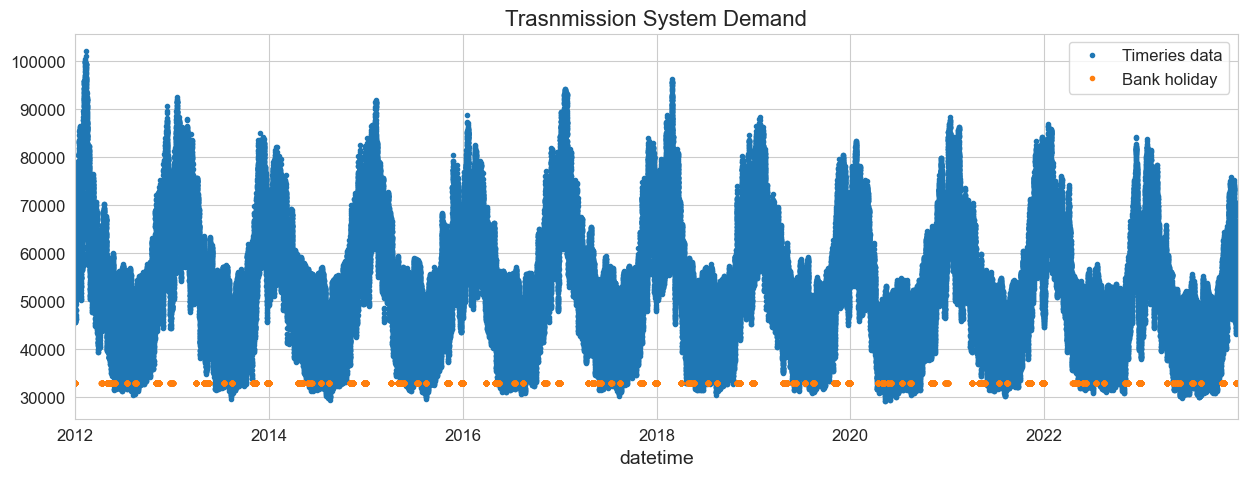

In [168]:
df_plot = data.copy()

fig, ax = plt.subplots(figsize=(15, 5))
df_plot["consommation"].plot(
    style=".", ax=ax, title="Trasnmission System Demand", label="Timeries data"
)
(df_plot.query("is_holiday == 1")["is_holiday"] * 33000).plot(
    style=".", ax=ax, label="Bank holiday"
)
ax.legend();

That plot is great to see the behaviour of the time series data. I can see a decreasing trend and a clear yearly seasonality. <br>
Before dealing with outliers, in the above graph we can see a yearly trend, but we cannot focus on daily or weekly patterns. Therefore, let's create a new plot focusing on a single week:

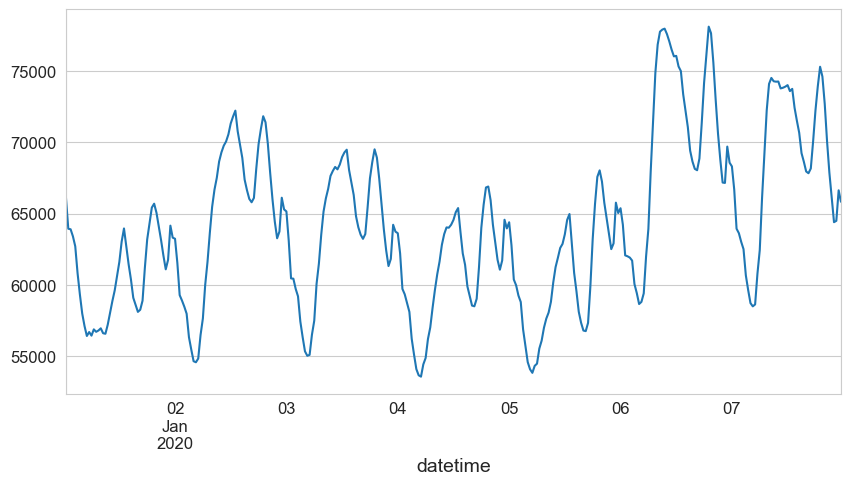

In [169]:
df_plot.loc[(df_plot.index > "01-01-2020") & (df_plot.index < "01-08-2020")][
    "consommation"
].plot(figsize=(10, 5));

It seems our data are valid and good for exploration.
Now I will explore the distribution of electricity demand with respect the different features, such as as hour, month or year. This is a great way to understand the seasonalities in the time series.

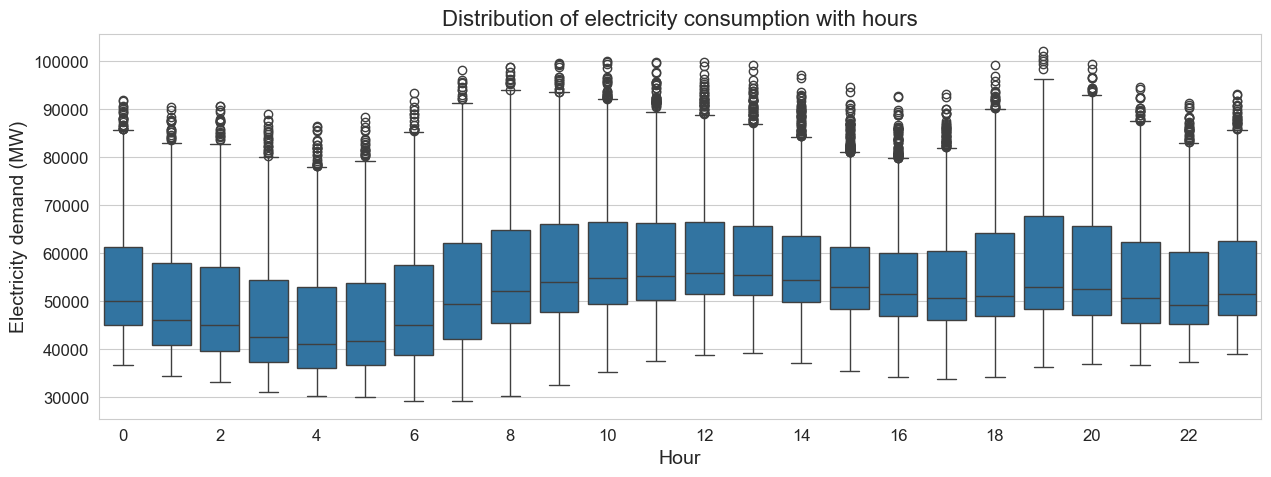

In [170]:
df_plot = data.copy()
df_plot["hour"] = df_plot.index.hour

fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="hour", y="consommation", data=df_plot)

ax.set_xticks(range(0, 24, 2))
ax.set_xticklabels(range(0, 24, 2))
ax.set_xlabel("Hour")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with hours");

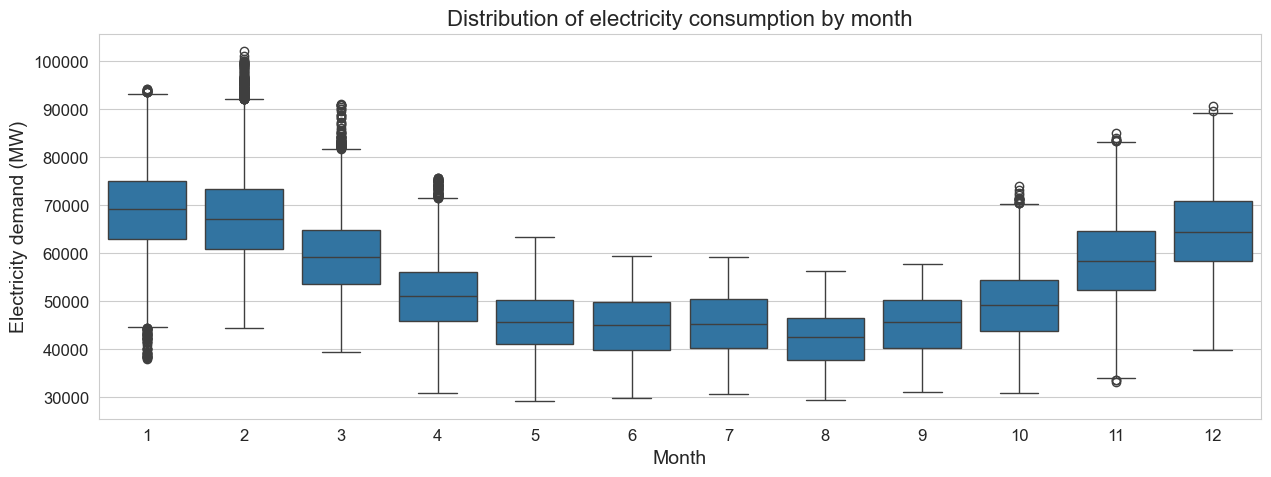

In [171]:
# Boxplot par mois
df_plot = data.copy()
df_plot["month"] = df_plot.index.month
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="month", y="consommation", data=df_plot)
ax.set_xlabel("Month")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption by month");

It seems that the lowest consumption occurs during the summer months. It's seems logical as there is not a lot of AC in France and people need to warm up there house thanks to electricity in winter months.
Let's plot on the years, for example 2018, to make sure that I selected the right variable in the above plot.

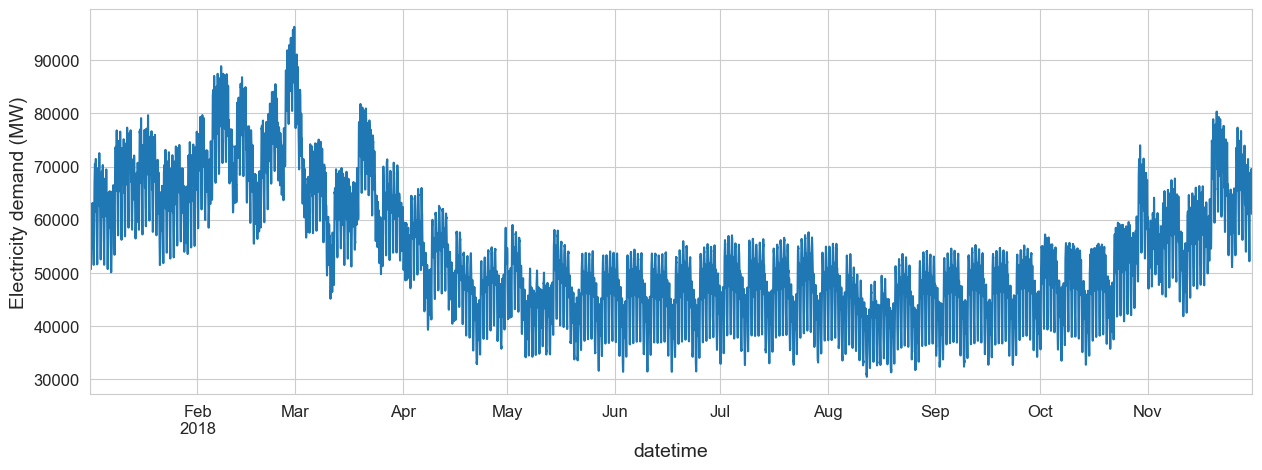

In [172]:
df_plot.loc[(df_plot.index > "01-01-2018") & (df_plot.index < "12-01-2018")]["consommation"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
);

This plot supports the finding from the previous graph.

Let's look at the effect of bank holidays on electricity consumption:



C:\Users\guill\AppData\Local\Temp\ipykernel_26480\3815876647.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]);


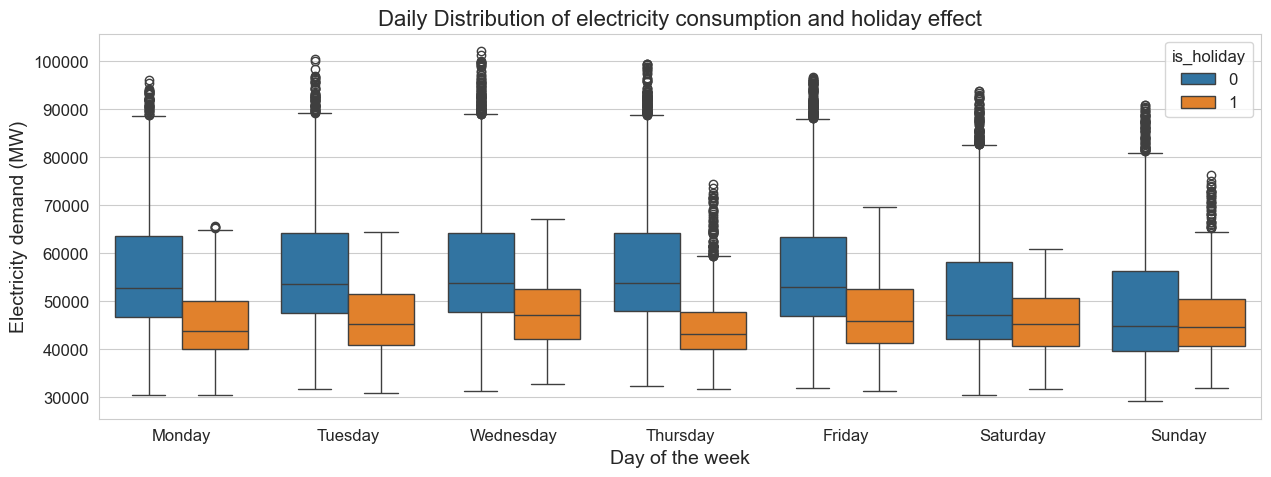

In [173]:
# Boxplot par jour de la semaine et effet jour férié
df_plot = data.copy()
df_plot["day_of_week"] = df_plot.index.dayofweek  # 0=Monday, 6=Sunday
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="day_of_week", y="consommation", data=df_plot, hue="is_holiday", ax=ax)
ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]);
ax.set_xlabel("Day of the week")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Daily Distribution of electricity consumption and holiday effect");

It seems that from Monday to Friday, the electricity consumption is on average lower on bank holidays, whereas it's the same on Saturdays & Sundays.

For non bank holiday, the demand on the weekend is lower than during week days.

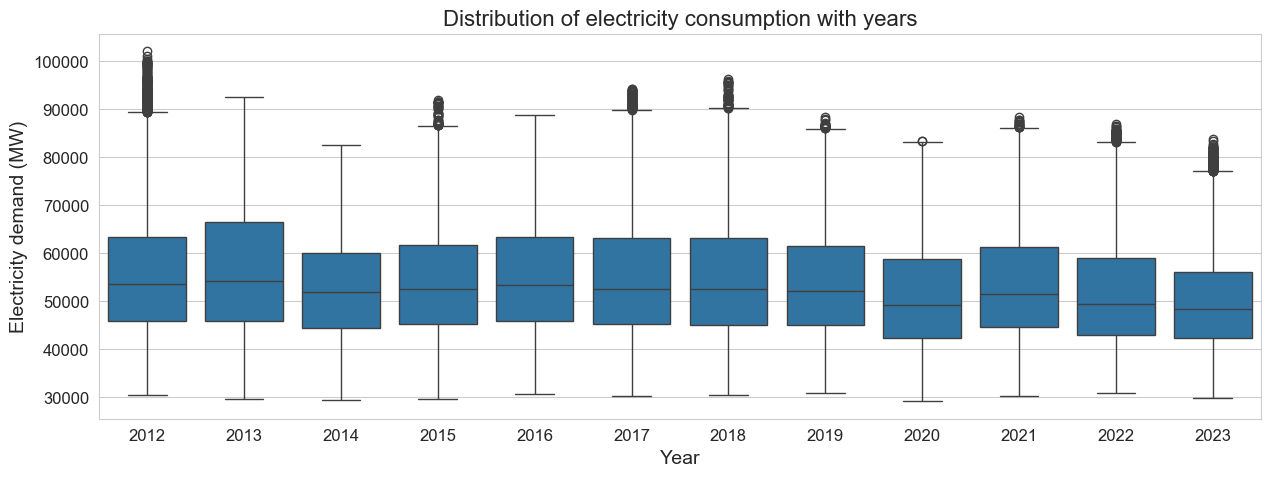

In [174]:
fig, ax = plt.subplots(figsize=(15, 5))
df_plot["year"] = df_plot.index.year
sns.boxplot(x="year", y="consommation", data=df_plot)

ax.set_xlabel("Year")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with years");

Although these are yearly average values, one can see a decreasing trend in the electricity consumption. We can overlay the electricity consumption of two years to see how they compare:

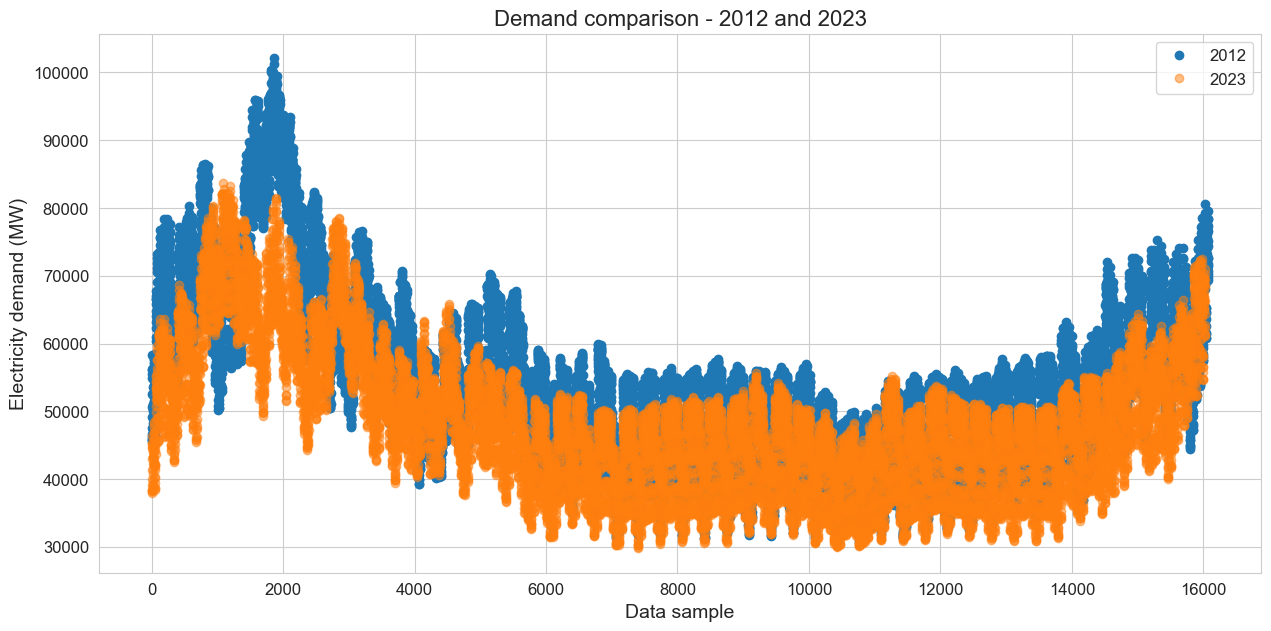

In [175]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(
    range(len(df_plot.loc[(df_plot.index > "01-01-2012") & (df_plot.index < "12-01-2012")]["consommation"])),
    df_plot.loc[(df_plot.index > "01-01-2012") & (df_plot.index < "12-01-2012")]["consommation"],
    "o",
    label="2012",
)

ax.plot(
    range(len(df_plot.loc[(df_plot.index > "01-01-2023") & (df_plot.index < "12-01-2023")]["consommation"])),
    df_plot.loc[(df_plot.index > "01-01-2023") & (df_plot.index < "12-01-2023")]["consommation"],
    "o",
    alpha=0.5,
    label="2023",
)
ax.set_xlabel("Data sample")
ax.set_ylabel("Electricity demand (MW)")
ax.legend(loc="best")
ax.set_title("Demand comparison - 2012 and 2023");

Again, this plot confirms that electricity consumption is decreasing in recent years.

<hr>

### XGBoost


Using XGBoost because it's a regression tool than does a great job with time series data and use multiple features.

Simple XGBoost model

The first XGBoost model is a simple model for which some of the parameters are defined and the data is split into train and test sets. This model is fairly simple, but it's a great baseline.

<hr>

Training - test split
First step is to split the data.


In [176]:
#Define the features and target variable
df = data.copy()
df["settlement_period"] = df.index.hour * 2 + (df.index.minute // 30) + 1
df["day_of_month"] = df.index.day
df["day_of_week"] = df.index.day_of_week
df["day_of_year"] = df.index.day_of_year
df["quarter"] = df.index.quarter
df["month"] = df.index.month
df["year"] = df.index.year
df["week_of_year"] = df.index.isocalendar().week.astype("int64")

#Add three lags to the dataset containing information from the previous 3 years
target_map =df["consommation"].to_dict()

df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
df["lag2"] = (df.index - pd.Timedelta("728 days")).map(target_map)
df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)

threshold_date_1 = "2020-01-01"
threshold_date_2 = "2022-01-01"

train_data = df.loc[df.index < threshold_date_1].copy()
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)].copy()
val_data = df.loc[df.index >= threshold_date_2].copy()

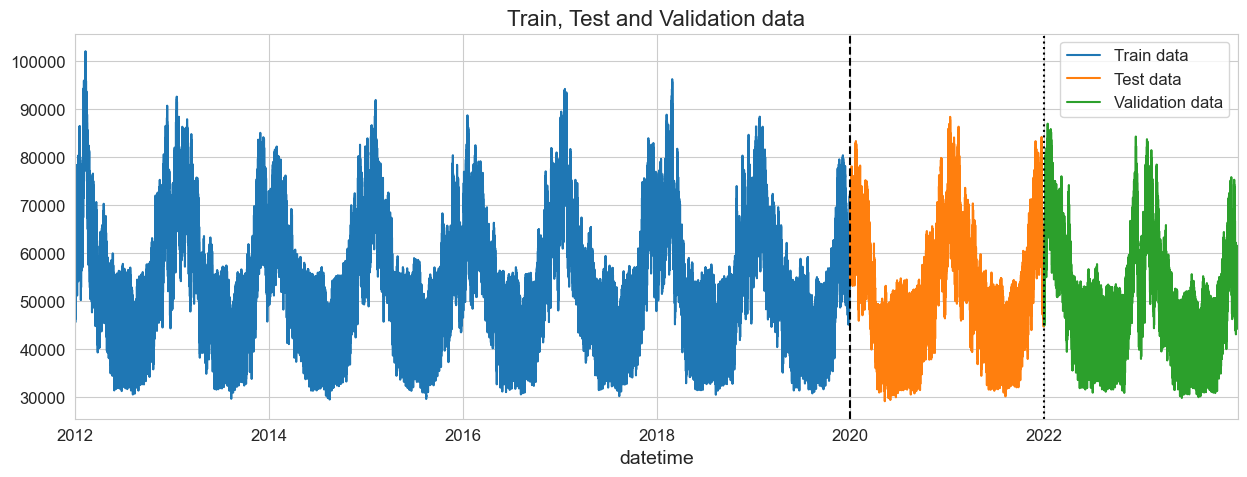

In [177]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data["consommation"].plot(ax=ax, label="Train data")
test_data["consommation"].plot(ax=ax, label="Test data")
val_data["consommation"].plot(ax=ax, label="Validation data")
ax.axvline(threshold_date_1, color="k", ls="--")
ax.axvline(threshold_date_2, color="k", ls=":")
ax.set_title("Train, Test and Validation data")
ax.legend();

In [178]:
Features = [
    "is_holiday",
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
]
Target = "consommation"

#Prepare the training, testing and validation datasets
X_train = train_data[Features]
y_train = train_data[Target]

X_test = test_data[Features]
y_test = test_data[Target]

X_val = val_data[Features]
y_val = val_data[Target]

#Initialize and train the model
xgb_simple = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.01,
    early_stopping_rounds=50,
    random_state=42,
)

xgb_simple.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test), (X_val, y_val)],
    verbose=100,
);
    


[0]	validation_0-rmse:11606.69810	validation_1-rmse:11499.29421
[100]	validation_0-rmse:7205.44320	validation_1-rmse:7416.11380
[200]	validation_0-rmse:6019.95139	validation_1-rmse:6394.28095
[300]	validation_0-rmse:5567.05750	validation_1-rmse:6016.35048
[400]	validation_0-rmse:5369.47333	validation_1-rmse:5861.10099
[499]	validation_0-rmse:5233.35195	validation_1-rmse:5759.62455


<Axes: >

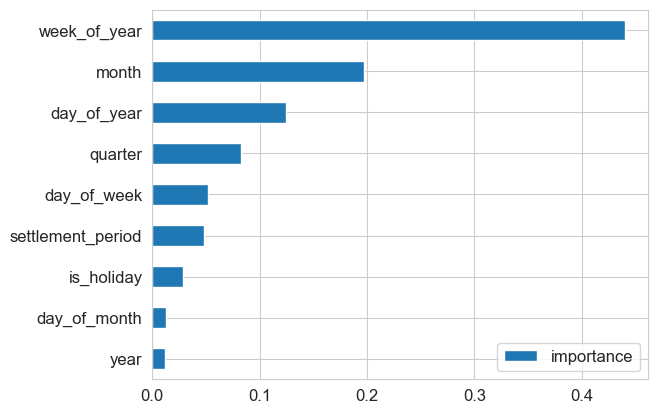

In [179]:
para_importance = pd.DataFrame(
    data= xgb_simple.feature_importances_,
    index= xgb_simple.get_booster().feature_names,
    columns=["importance"]
)

para_importance.sort_values("importance", ascending=True, inplace=True)
para_importance.plot(kind="barh")

In [180]:
result_frame = y_test.to_frame()
result_frame["pred_xgb_simple"] = xgb_simple.predict(X_test)

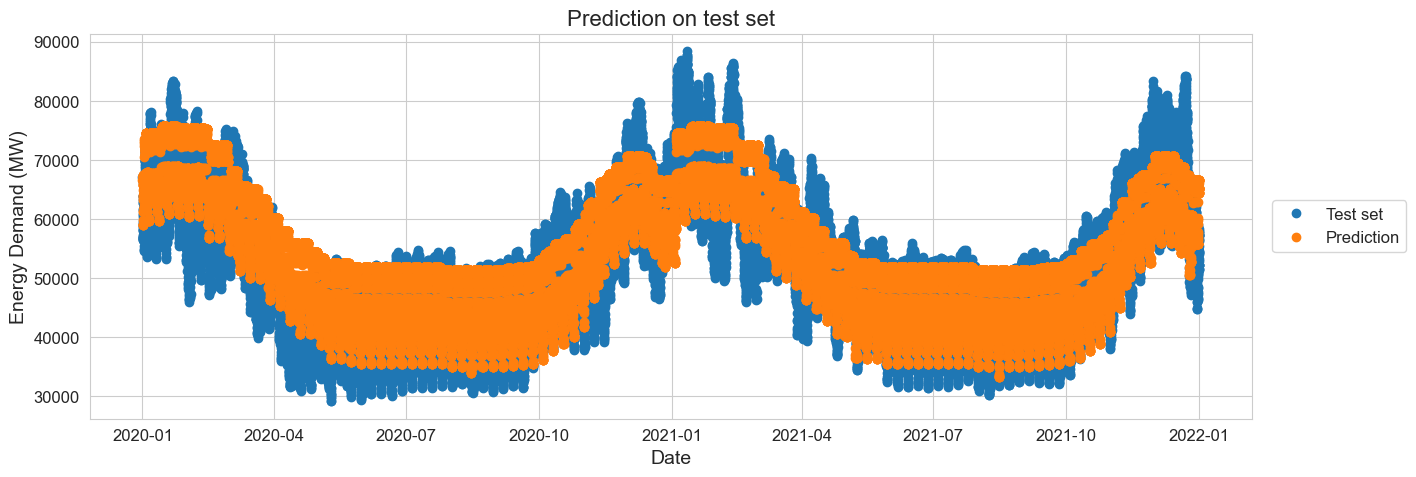

In [181]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["consommation"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["pred_xgb_simple"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

Let's focus on a single week to see how the individual predictions perform compared to the test set

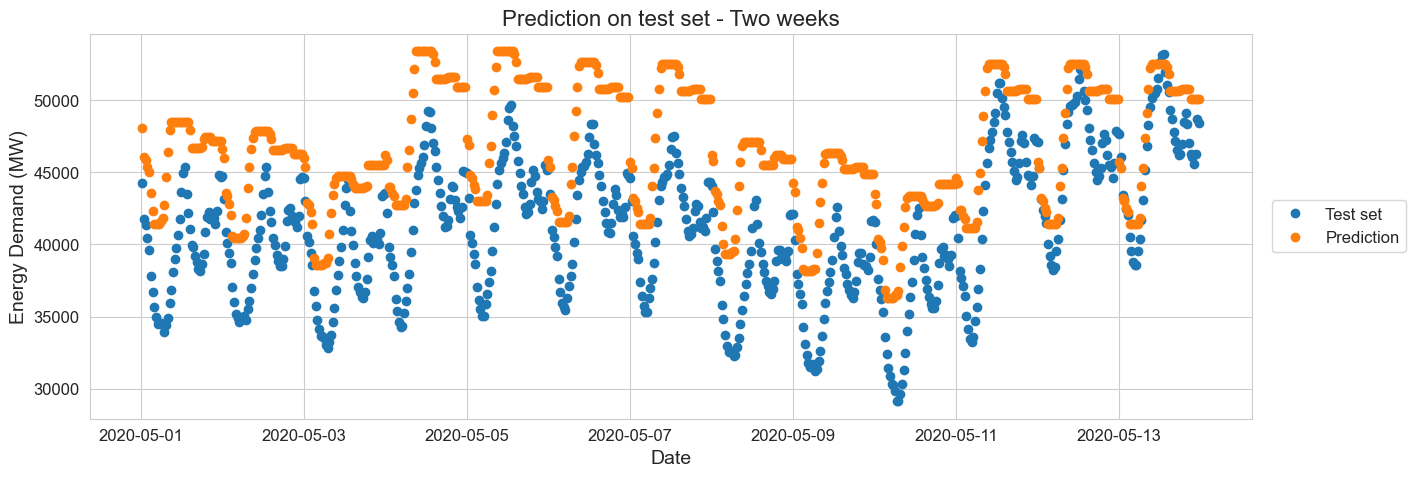

In [182]:
begin = "05-01-2020"
end = "05-14-2020"

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["consommation"],
    "o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_simple"
    ],
    "o",
    label="Prediction",
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

As can be seen, the model struggles to capture the peaks and valleys. In the next section I will use grid search to see if tuning the model hyperparameters leads to a better prediction.

In [183]:
mape_xgboost_simple = mean_absolute_percentage_error(
    y_test, result_frame["pred_xgb_simple"]
)

rmse_xgboost_simple = np.sqrt(mean_squared_error(y_test, result_frame["pred_xgb_simple"]))

print(
    "Mean Absolute Percentage Error of the simple model is: %.2f" % mape_xgboost_simple
)

print(
    "Root Mean Squared Error of the simple models is: %.2f MW" % rmse_xgboost_simple
)

Mean Absolute Percentage Error of the simple model is: 8.24
Root Mean Squared Error of the simple models is: 5233.35 MW


### XGBoost with Cross validation and Grid Search¶
The model above is a good starting point, but it's still underfitted to the data. One can run the model again and change the hyperparameters,but it isn't the right way to train a model if we want to avoid overfitting. This problem can be solved by using cross validation and grid search.

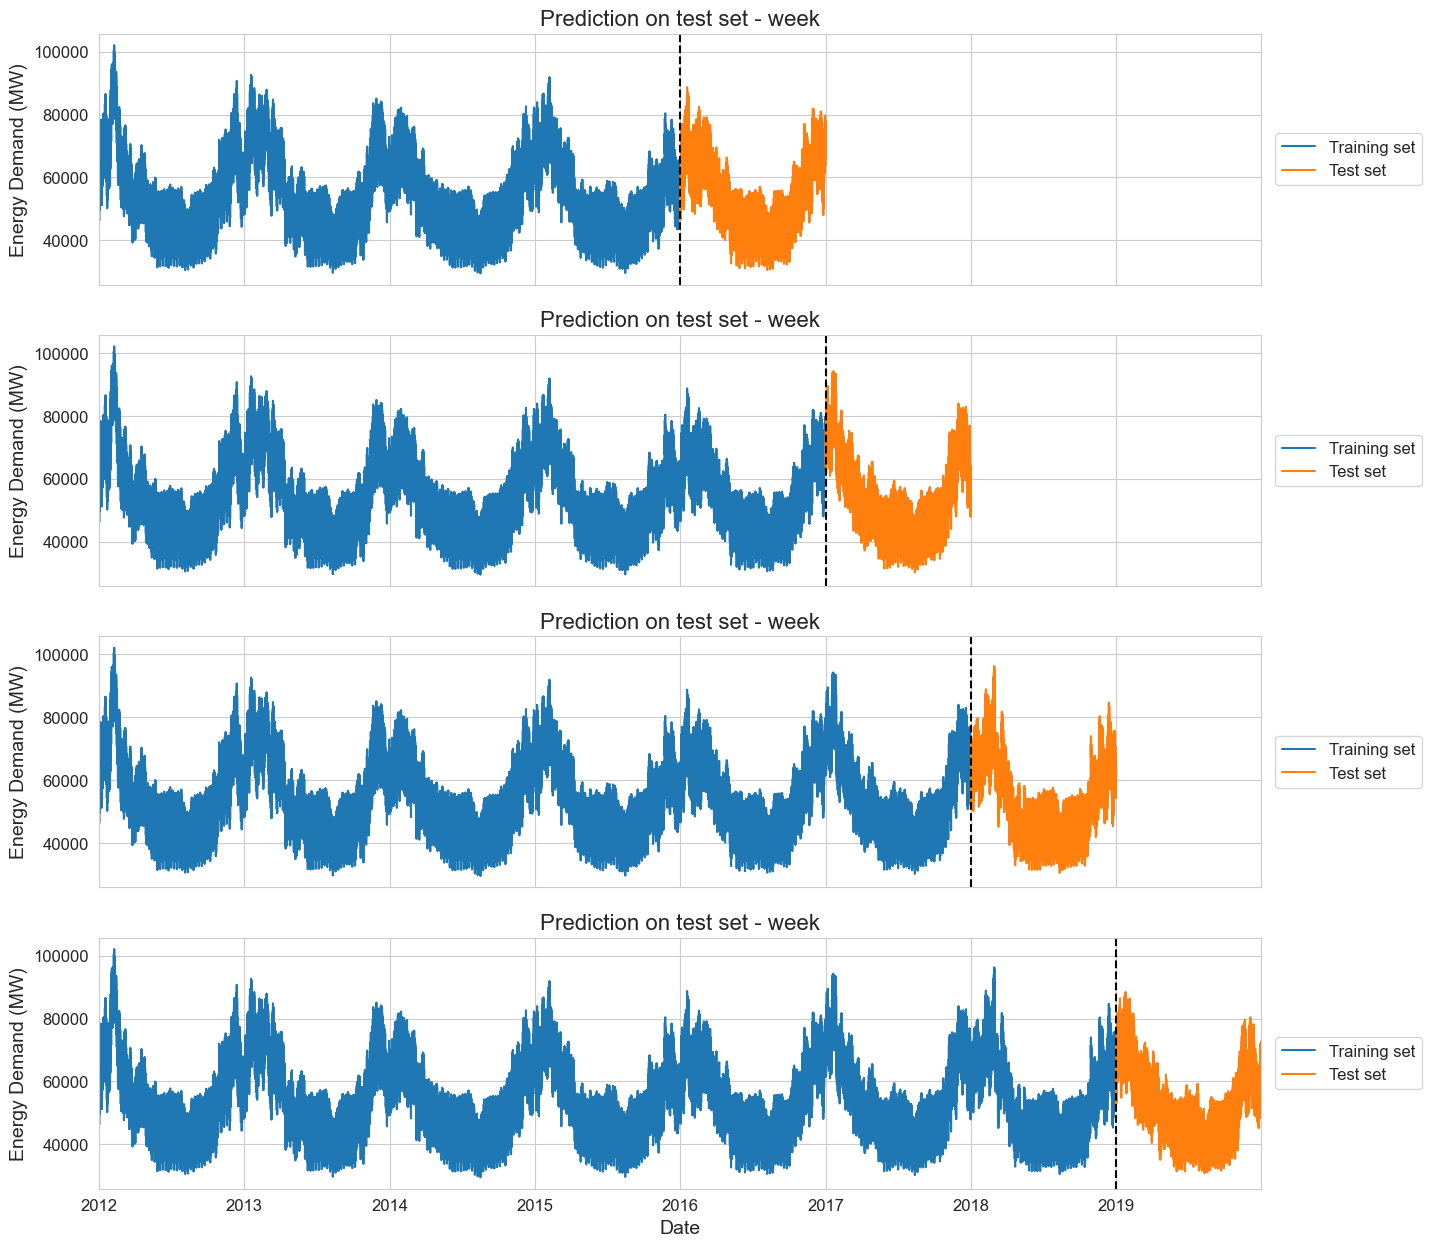

In [184]:
n_years_test = 1
tss = TimeSeriesSplit(n_splits=4, test_size=48 * 365 * n_years_test, gap=48)

fig, axes = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_index, test_index in tss.split(df[df.index<threshold_date_1]):

    train = df.iloc[train_index]
    test = df.iloc[test_index]

    train["consommation"].plot(
        ax=axes[fold], label="Training set", title=f"Data Train-test split fold {fold}",
    )
    test["consommation"].plot(ax=axes[fold], label="Test set")
    axes[fold].axvline(test.index.min(), color="k", ls="--")
    axes[fold].legend(loc="center", bbox_to_anchor=(1.075, 0.5))

    axes[fold].set_title("Prediction on test set - week")
    axes[fold].set_ylabel("Energy Demand (MW)")
    axes[fold].set_xlabel("Date");
    fold += 1

One can combine the cross validation technique for time series, called TimeSeriesSplit with GridSearchCV to find the best parameters for the XGBoost model.

In [185]:
def clean_xy(X, y):
    X = X.copy()
    # cast bool -> int8, forcer numérique sinon NaN
    for c in X.columns:
        if X[c].dtype == bool:
            X[c] = X[c].astype("int8")
        elif X[c].dtype.kind not in "iuif":
            X[c] = pd.to_numeric(X[c], errors="coerce")
    X = X.replace([np.inf, -np.inf], np.nan)
    y = pd.to_numeric(y, errors="coerce")
    y = y.replace([np.inf, -np.inf], np.nan)
    # aligner les index puis dropna de façon jointe
    df = X.join(y.rename("_y_"), how="inner")
    df = df.dropna()
    return df[X.columns], df["_y_"]

train_data.index = pd.Index(train_data.index)
test_data.index = pd.Index(test_data.index)

FEATURES_CV = [
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
    "lag1",
    "lag2",
    "lag3",
    "is_holiday",
]
TARGET = "consommation"

X_train_cv, y_train_cv = clean_xy(train_data[FEATURES_CV], train_data[TARGET])
X_val_cv,   y_val_cv   = clean_xy(val_data[FEATURES_CV],   val_data[TARGET])
X_test_cv,  y_test_cv  = clean_xy(test_data[FEATURES_CV],  test_data[TARGET])  # si besoin

In [186]:
assert X_train_cv.shape[0] == y_train_cv.shape[0]
assert X_val_cv.shape[0]   == y_val_cv.shape[0]
assert X_train_cv.columns.tolist() == X_val_cv.columns.tolist()
assert np.isfinite(X_train_cv.values).all() and np.isfinite(y_train_cv.values).all()
assert np.isfinite(X_val_cv.values).all()   and np.isfinite(y_val_cv.values).all()


In [187]:
# Define fit parameters to allow early stopping in GridSearchCV
fit_params = {
    "eval_set": [(X_val_cv, y_val_cv)],
    "verbose": 500,  
}

# Define estimator
estimator = xgb.XGBRegressor(
    objective="reg:squarederror",
    learning_rate=0.01,
    tree_method="hist",
    device="cpu",          # <- explicite, plus de warning GPU
    random_state=43,
    n_jobs=-1,
            
)

param_search = {
    "max_depth": [3, 5],
    "n_estimators": [350, 500, 650],
    "subsample": [0.95, 0.8, 0.7],
}

xgb_search = GridSearchCV(
    estimator=estimator,
    cv=tss,
    param_grid=param_search,
    scoring="neg_root_mean_squared_error",
    error_score="raise",
    verbose=3,
    return_train_score=True,
)
xgb_search.fit(X_train_cv, y_train_cv)

best_params = xgb_search.best_params_

# Ré-entraîne une seule fois avec early-stopping sur train+val
final_model = xgb.XGBRegressor(
    **best_params,
    objective="reg:squarederror",
    learning_rate=0.01,
    tree_method="hist",
    device="cpu",
    random_state=43,
    n_jobs=-1,
    early_stopping_rounds=50,
    eval_metric="rmse",
)

final_model.fit(
    pd.concat([X_train_cv, X_val_cv]),
    pd.concat([y_train_cv, y_val_cv]),
    eval_set=[(X_val_cv, y_val_cv)],
    verbose=False,
)


Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=(train=-2796.724, test=-4992.636) total time=   0.2s
[CV 2/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=(train=-3305.896, test=-5260.361) total time=   0.3s
[CV 3/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=(train=-3669.237, test=-5267.921) total time=   0.3s
[CV 4/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=(train=-3994.843, test=-4539.460) total time=   0.5s
[CV 1/4] END max_depth=3, n_estimators=350, subsample=0.8;, score=(train=-2790.798, test=-4998.334) total time=   0.2s
[CV 2/4] END max_depth=3, n_estimators=350, subsample=0.8;, score=(train=-3298.165, test=-5248.703) total time=   0.2s
[CV 3/4] END max_depth=3, n_estimators=350, subsample=0.8;, score=(train=-3676.321, test=-5240.145) total time=   0.4s
[CV 4/4] END max_depth=3, n_estimators=350, subsample=0.8;, score=(train=-3999.440, test=-4541.069) to

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,'cpu'
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,'rmse'


In [188]:
xgb_search.best_params_

{'max_depth': 3, 'n_estimators': 350, 'subsample': 0.8}

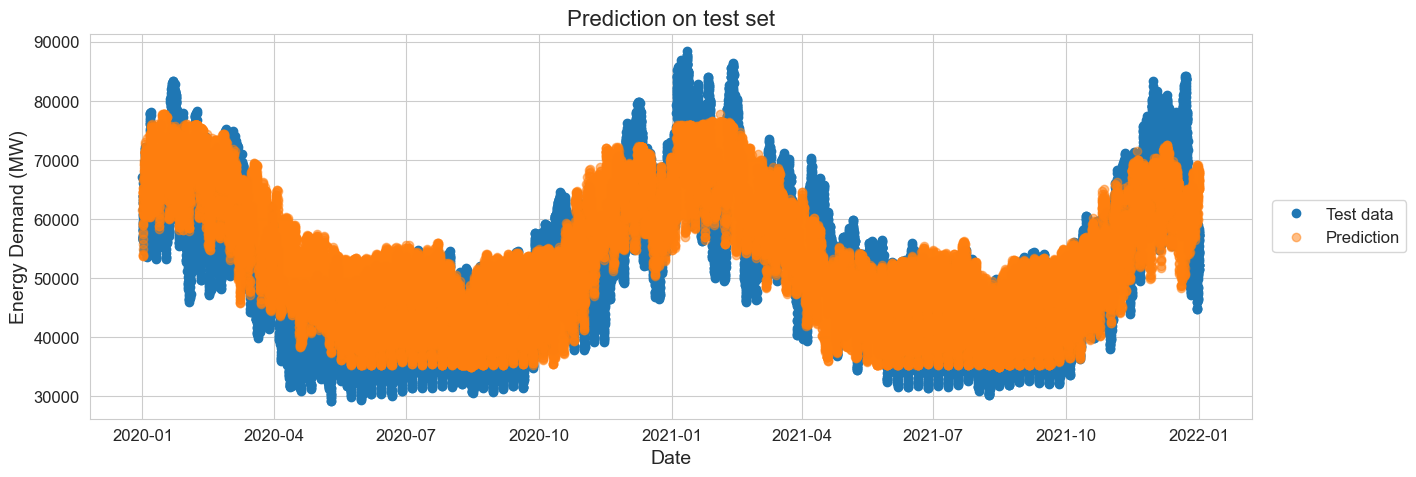

In [189]:
result_frame["pred_xgb_cv_gs"] = xgb_search.predict(X_test_cv)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["consommation"], "o", label="Test data")
ax.plot(
    result_frame.index,
    result_frame["pred_xgb_cv_gs"],
    "o",
    label="Prediction",
    alpha=0.5,
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

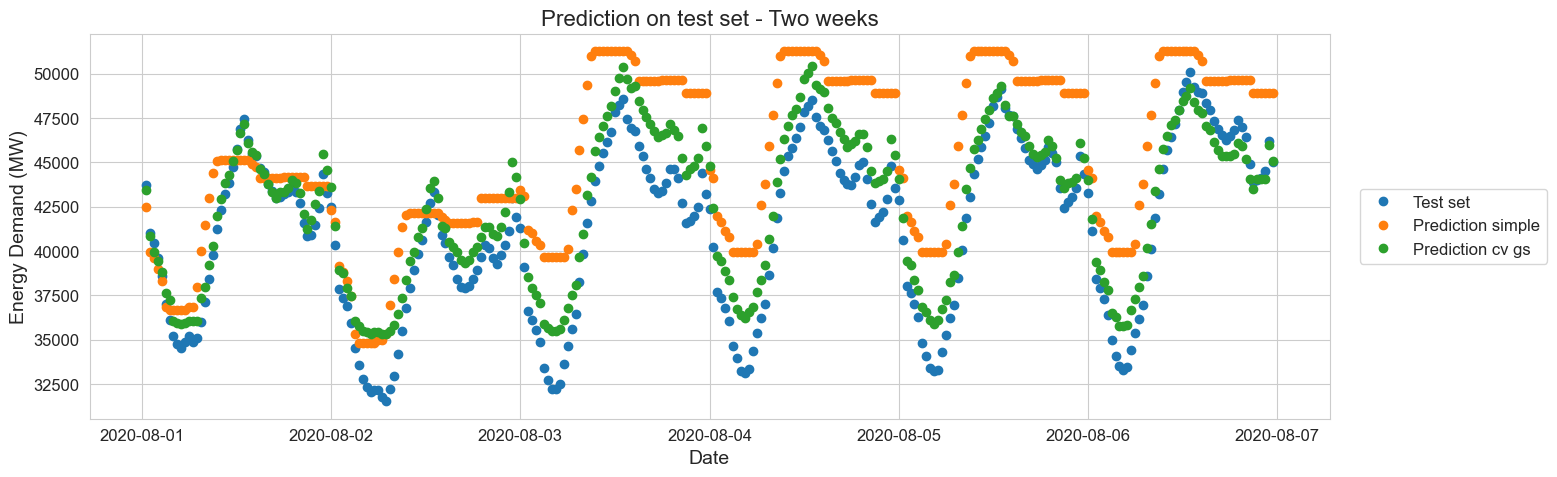

In [190]:
begin = "08-01-2020"
end = "08-7-2020"

fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["consommation"],
    "o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_simple"
    ],
    "o",
    label="Prediction simple",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_cv_gs"
    ],
    "o",
    label="Prediction cv gs",
)

ax.legend(loc="center", bbox_to_anchor=(1.1, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [191]:
mape_xgboost_cv = mean_absolute_percentage_error(
    y_test, result_frame["pred_xgb_cv_gs"]
)

rmse_xgboost_cv = np.sqrt(mean_squared_error(y_test, result_frame["pred_xgb_cv_gs"]))
print(
    "Mean Absolute Percentage Error of the cross-validated model is: %.2f"
    % mape_xgboost_cv
)

print(
    "Root Mean Squared Error of the cross-validated model is: %.2f MW" % rmse_xgboost_cv
)

Mean Absolute Percentage Error of the cross-validated model is: 7.61
Root Mean Squared Error of the cross-validated model is: 5220.50 MW


Let's predict the feature as the best parameters as been found

In [192]:
X_all = df[FEATURES_CV]
y_all = df[TARGET]

xgb_best = xgb_search.best_estimator_
xgb_best.set_params(n_jobs=-1, early_stopping_rounds=50,verbose=100)
xgb_best.fit(
    X_all,
    y_all,
    eval_set=[(X_all, y_all)],
);

[0]	validation_0-rmse:11824.45655
[1]	validation_0-rmse:11740.82818
[2]	validation_0-rmse:11658.25922
[3]	validation_0-rmse:11576.61362
[4]	validation_0-rmse:11496.10728
[5]	validation_0-rmse:11416.66123
[6]	validation_0-rmse:11338.26749
[7]	validation_0-rmse:11260.61568
[8]	validation_0-rmse:11184.23015
[9]	validation_0-rmse:11108.41853
[10]	validation_0-rmse:11034.09765
[11]	validation_0-rmse:10960.42271
[12]	validation_0-rmse:10888.00126
[13]	validation_0-rmse:10815.93307
[14]	validation_0-rmse:10745.16571
[15]	validation_0-rmse:10674.97009
[16]	validation_0-rmse:10605.59842
[17]	validation_0-rmse:10537.17494
[18]	validation_0-rmse:10470.01907
[19]	validation_0-rmse:10403.43678
[20]	validation_0-rmse:10338.03835
[21]	validation_0-rmse:10272.79686
[22]	validation_0-rmse:10208.96553
[23]	validation_0-rmse:10146.04907


c:\Users\guill\OneDrive\Bureau\VSCode Project\Lib\site-packages\xgboost\callback.py:386: UserWarning: [14:07:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[24]	validation_0-rmse:10081.79596
[25]	validation_0-rmse:10019.68557
[26]	validation_0-rmse:9957.02080
[27]	validation_0-rmse:9896.41345
[28]	validation_0-rmse:9835.31456
[29]	validation_0-rmse:9776.53931
[30]	validation_0-rmse:9718.95535
[31]	validation_0-rmse:9660.14497
[32]	validation_0-rmse:9603.44616
[33]	validation_0-rmse:9546.20481
[34]	validation_0-rmse:9489.86657
[35]	validation_0-rmse:9435.47792
[36]	validation_0-rmse:9380.45469
[37]	validation_0-rmse:9327.26968
[38]	validation_0-rmse:9274.71504
[39]	validation_0-rmse:9223.25379
[40]	validation_0-rmse:9170.85903
[41]	validation_0-rmse:9120.31827
[42]	validation_0-rmse:9070.91178
[43]	validation_0-rmse:9022.27798
[44]	validation_0-rmse:8972.55569
[45]	validation_0-rmse:8923.44662
[46]	validation_0-rmse:8875.04920
[47]	validation_0-rmse:8828.72693
[48]	validation_0-rmse:8782.68941
[49]	validation_0-rmse:8736.02389
[50]	validation_0-rmse:8691.60717
[51]	validation_0-rmse:8646.32759
[52]	validation_0-rmse:8602.58817
[53]	validat

In [193]:
def settlement_period(df):
    """
    Determine settlement period using dataframe index date. Each settlement period
    equates to 30-minute interval.
    Settlement period equal to 0 corresponds with 00:00:00 and settlement period 48
    corresponds with 23:30:00

    Args:
        - df: time series dataframe containing dates in the future

    Returns:
        - df: time series dataframe with settlement period column
    """

    df = df.copy()

    settlement_period_array = (
        np.array(df.index.hour.to_list()) * 2 + np.array(df.index.minute.to_list()) / 30 + 1
    ).astype(int)


    df["settlement_period"] = settlement_period_array

    return df


#Define the features and target variable
def create_features(data):
    """
    Create time series features based on time series index.

    Args:
        - data: time series dataframe

    Returns:
        - df: time series dataframe with new features
    """
    df = data.copy()
    df["settlement_period"] = df.index.hour * 2 + (df.index.minute // 30) + 1
    df["day_of_month"] = df.index.day
    df["day_of_week"] = df.index.day_of_week
    df["day_of_year"] = df.index.day_of_year
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["week_of_year"] = df.index.isocalendar().week.astype("int64")
    return df

#Add three lags to the dataset containing information from the previous 3 years
def add_lags(df):
    """
    Add lag features to the dataframe. Lag features are based on the previous
    3 years of data.

    Args:
        - df: time series dataframe

    Returns:
        - df: time series dataframe with new lag features
    """
    target_map =df["consommation"].to_dict()

    df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("728 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    return df


# Create empty lists to store data
holiday_names = []
holiday_dates = []
holiday_names_observed = []
holiday_dates_observed = []

# Par :
for row in holidays_df.itertuples():
    date = row.date
    name = getattr(row, 'name', None)  # Si la colonne 'name' existe
    holiday_dates.append(date)
    holiday_names.append(name)
    if name and "Observed" in name:
        if holiday_dates_observed: holiday_dates_observed.pop()
        if holiday_names_observed: holiday_names_observed.pop()
    holiday_names_observed.append(name)
    holiday_dates_observed.append(np.datetime64(date))

holiday_dates_observed[:5]

[np.datetime64('2012-01-01T00:00:00.000000'),
 np.datetime64('2012-04-09T00:00:00.000000'),
 np.datetime64('2012-05-01T00:00:00.000000'),
 np.datetime64('2012-05-08T00:00:00.000000'),
 np.datetime64('2012-05-17T00:00:00.000000')]

In [194]:
prediction_days = 210

future = pd.date_range(
    str(df.index.max())[0:10],
    df.index.max() + datetime.timedelta(days=prediction_days),
    freq="30min",
)

future_df = pd.DataFrame(index=future)
future_df = settlement_period(future_df)
future_df["is_future"] = True
df["is_future"] = False

# Create a dataframe containing the original data and the predict df
df_and_future = pd.concat([df, future_df])

# add features and lag
# lag values will change w.r.t original dataframe
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

# add bank holidays in future dataframe
df_and_future_wprediction = df_and_future.query("is_future").copy()

df_and_future_wprediction["settlement_date"] = df_and_future_wprediction.index.date
df_and_future_wprediction["is_holiday"] = df_and_future_wprediction["settlement_date"].apply(
    lambda x: pd.to_datetime(x) in holiday_dates_observed
)
df_and_future_wprediction["is_holiday"] = df_and_future_wprediction["is_holiday"].astype(int)

df_and_future_wprediction.tail()

,consommation,fioul,charbon,gaz,nucléaire,eolien,solaire,hydraulique,pompage,bioénergies,...,day_of_year,quarter,month,year,week_of_year,lag1,lag2,lag3,is_future,settlement_date
2024-07-28 21:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,210,3,7,2024,30,39082.0,41901.0,39165.0,True,2024-07-28
2024-07-28 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,210,3,7,2024,30,39345.0,42259.0,39603.0,True,2024-07-28
2024-07-28 22:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,210,3,7,2024,30,40048.0,43087.0,40419.0,True,2024-07-28
2024-07-28 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,210,3,7,2024,30,41254.0,44345.0,42166.0,True,2024-07-28
2024-07-28 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,210,3,7,2024,30,40183.0,43168.0,41250.0,True,2024-07-28


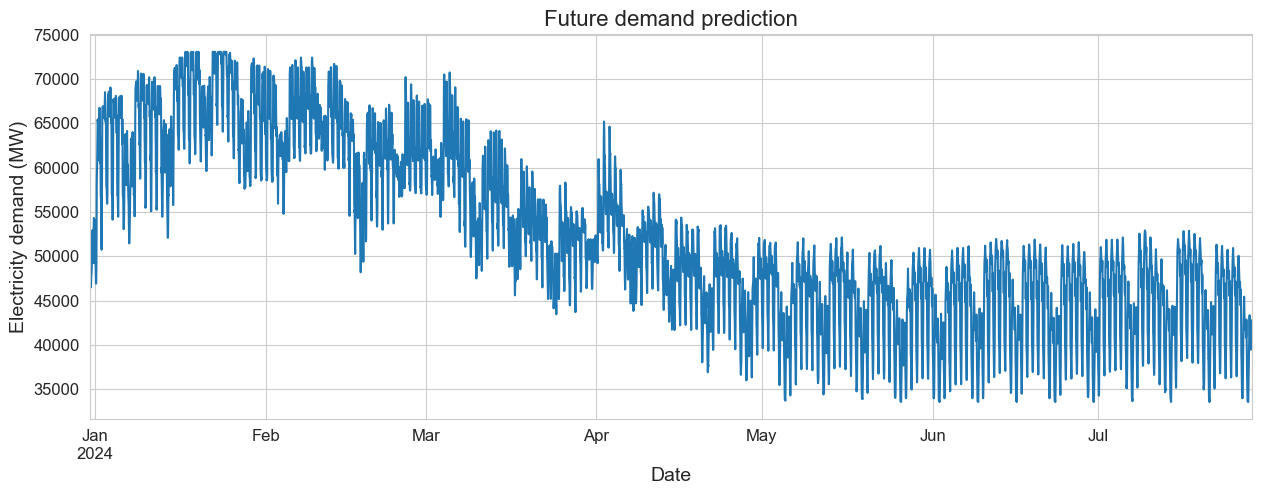

In [195]:
df_and_future_wprediction["pred_xgboost"] = xgb_best.predict(
    df_and_future_wprediction[FEATURES_CV]
)


fig, ax = plt.subplots(figsize=(15, 5))
df_and_future_wprediction["pred_xgboost"].plot(figsize=(15, 5), style="-", ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Future demand prediction");

<hr>

### Prophet

<hr>

I have to rename columns so the Prophet can work

In [196]:
def to_prophet_df(y_series: pd.Series) -> pd.DataFrame:
    """
    y_series : Series avec DatetimeIndex et nom de colonne 'consommation' (ou peu importe)
    Retourne un DataFrame Prophet propre: colonnes ['ds','y'] sans valeurs non-parsables.
    """
    # 1) Construire proprement ds depuis l'index (aucun 'settlement_date' impliqué)
    df = (y_series.rename('y')        # nom de la cible
                  .to_frame()
                  .rename_axis('ds')  # l'index (DatetimeIndex) sera ds
                  .reset_index())

    # 2) Sécuriser le type: si ce n'est pas déjà datetime64, on convertit en coerce + filtre
    if not np.issubdtype(df['ds'].dtype, np.datetime64):
        ds_parsed = pd.to_datetime(df['ds'], errors='coerce')
        bad = df[ds_parsed.isna()]
        if not bad.empty:
            print("⚠️ Lignes retirées car 'ds' non convertible en datetime :")
            print(bad.head())
        df = df[ds_parsed.notna()].copy()
        df['ds'] = ds_parsed[ds_parsed.notna()]

    # 3) Tri + suppression d’éventuels doublons sur ds
    df = df.sort_values('ds').drop_duplicates(subset='ds', keep='last').reset_index(drop=True)
    return df

# Construire les 4 jeux Prophet proprement depuis les Series y_*
train_data_prophet = to_prophet_df(y_train)
val_data_prophet   = to_prophet_df(y_val)
test_data_prophet  = to_prophet_df(y_test)
all_data_prophet   = to_prophet_df(y_all)

train_data_prophet.head()


,ds,y
0,2012-01-01 00:00:00,58315.0
1,2012-01-01 00:30:00,58315.0
2,2012-01-01 01:00:00,56231.0
3,2012-01-01 01:30:00,56075.0
4,2012-01-01 02:00:00,55532.0


In [197]:
%%time
prophet_model = Prophet()
prophet_model.fit(train_data_prophet)

np.random.seed(43)
prophet_predict_df = prophet_model.predict(test_data_prophet)
prophet_predict_df.head()

14:07:40 - cmdstanpy - INFO - Chain [1] start processing
14:09:51 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 15.3 s
Wall time: 2min 26s


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01 00:00:00,53438.057037,58036.019666,69556.448229,53438.057037,53438.057037,10201.449197,10201.449197,10201.449197,-332.827228,...,2136.727547,2136.727547,2136.727547,8397.548878,8397.548878,8397.548878,0.0,0.0,0.0,63639.506235
1,2020-01-01 00:30:00,53438.038456,57478.582238,68717.715834,53438.038456,53438.038456,9712.469314,9712.469314,9712.469314,-827.910922,...,2137.296611,2137.296611,2137.296611,8403.083625,8403.083625,8403.083625,0.0,0.0,0.0,63150.507769
2,2020-01-01 01:00:00,53438.019874,56947.059826,67854.882380,53438.019874,53438.019874,8899.579954,8899.579954,8899.579954,-1648.146625,...,2139.082003,2139.082003,2139.082003,8408.644576,8408.644576,8408.644576,0.0,0.0,0.0,62337.599828
3,2020-01-01 01:30:00,53438.001293,55730.327096,67630.527838,53438.001293,53438.001293,7734.294235,7734.294235,7734.294235,-2822.006516,...,2142.069053,2142.069053,2142.069053,8414.231698,8414.231698,8414.231698,0.0,0.0,0.0,61172.295527
4,2020-01-01 02:00:00,53437.982711,54065.457546,65391.439227,53437.982711,53437.982711,6280.488451,6280.488451,6280.488451,-4285.594356,...,2146.237849,2146.237849,2146.237849,8419.844959,8419.844959,8419.844959,0.0,0.0,0.0,59718.471162


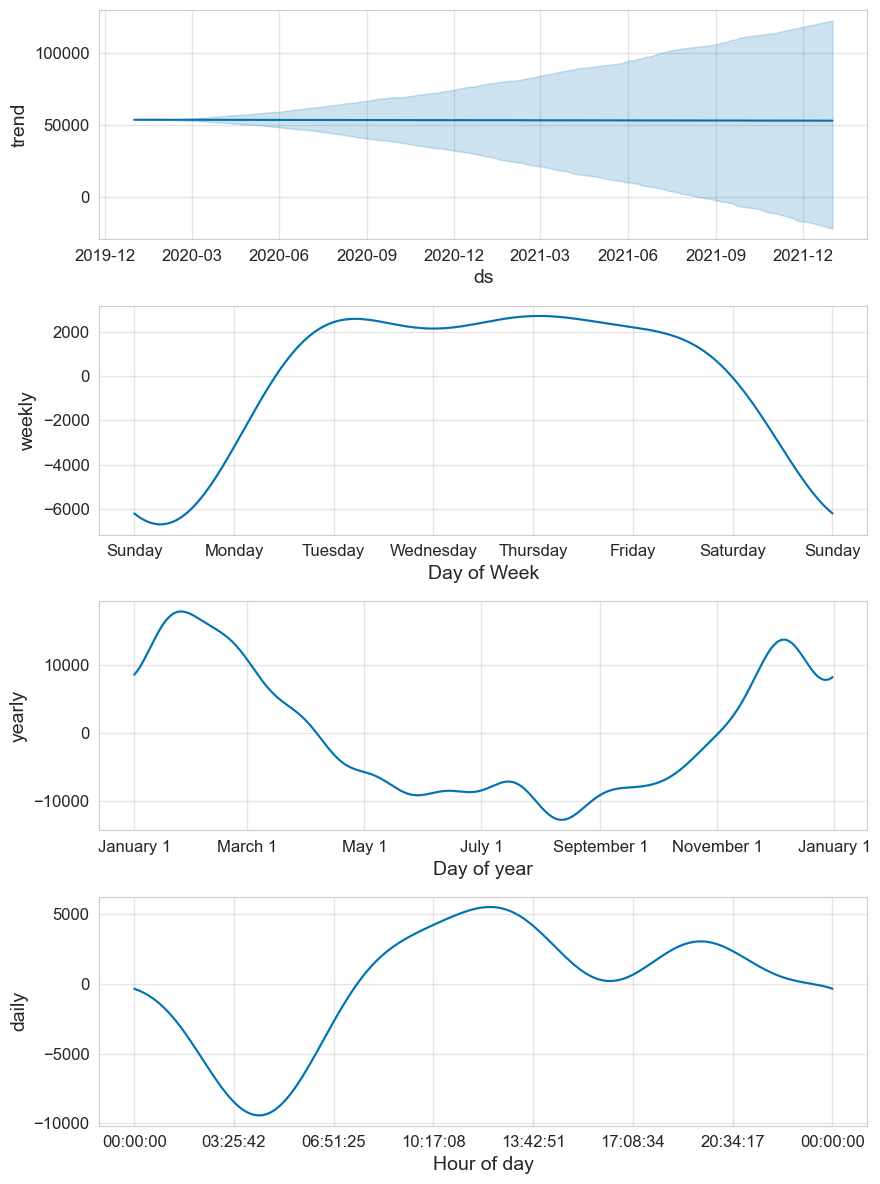

In [198]:
prophet_model.plot_components(prophet_predict_df);

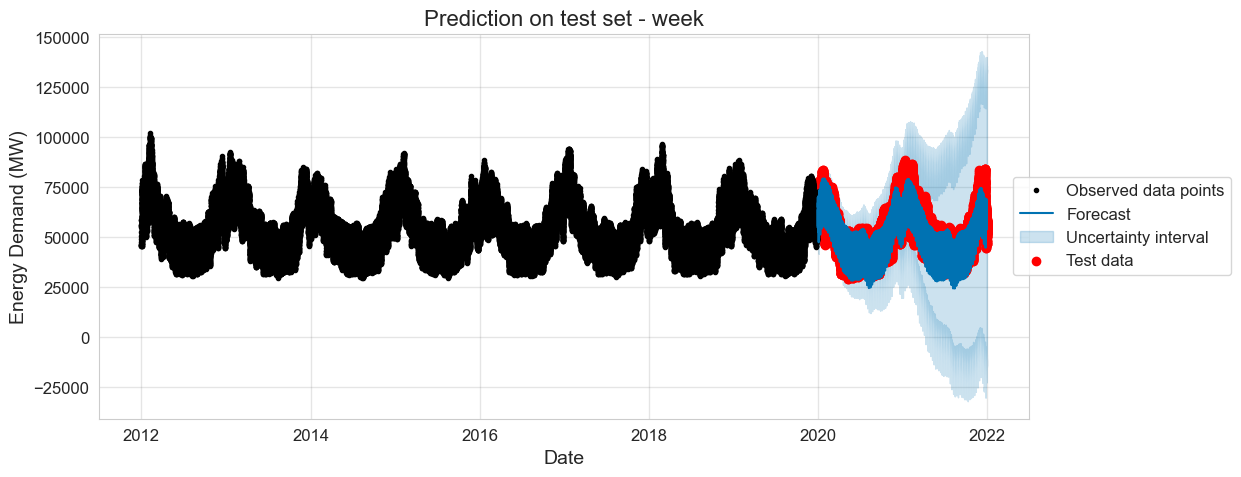

In [199]:
fig, ax = plt.subplots(figsize=(12, 5))

prophet_model.plot(prophet_predict_df, ax=ax, include_legend=True)
ax.scatter(y_test.to_frame().index, y_test.to_frame()["consommation"], color='r', label="Test data")
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1)

ax.set_title("Prediction on test set - week")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

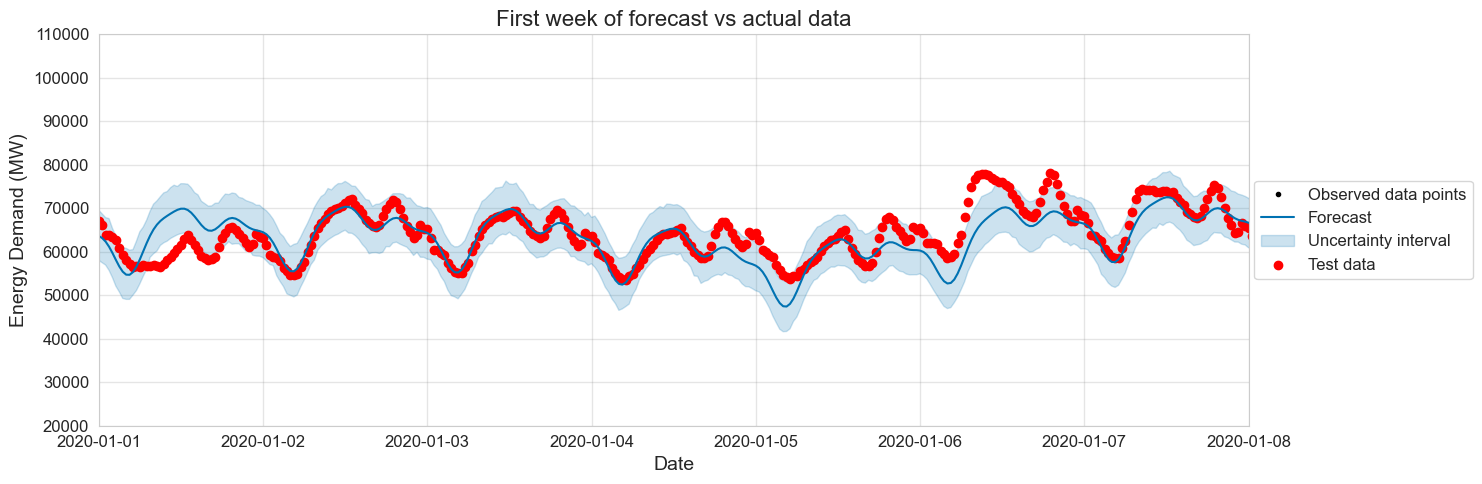

In [208]:
threshold_date = "2020-01-01"
# borne inférieure : début du test
lower = pd.to_datetime(threshold_date)

# borne supérieure : une semaine après
upper = lower + pd.Timedelta(days=7)

fig, ax = plt.subplots(figsize=(15,5))
prophet_model.plot(prophet_predict_df, ax=ax, include_legend=True)

# nettoyage au cas où
x_idx = pd.to_datetime(y_test.index, errors="coerce")
y_test_clean = y_test.loc[x_idx.notna()].copy()
y_test_clean.index = x_idx[x_idx.notna()]

ax.scatter(y_test_clean.index, y_test_clean.to_numpy(), color='r', label="Test data")

# borne X = une semaine
ax.set_xlim(lower, upper)
ax.set_ylim(20000, 110000)
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1)
ax.set_title("First week of forecast vs actual data")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date")
plt.tight_layout()


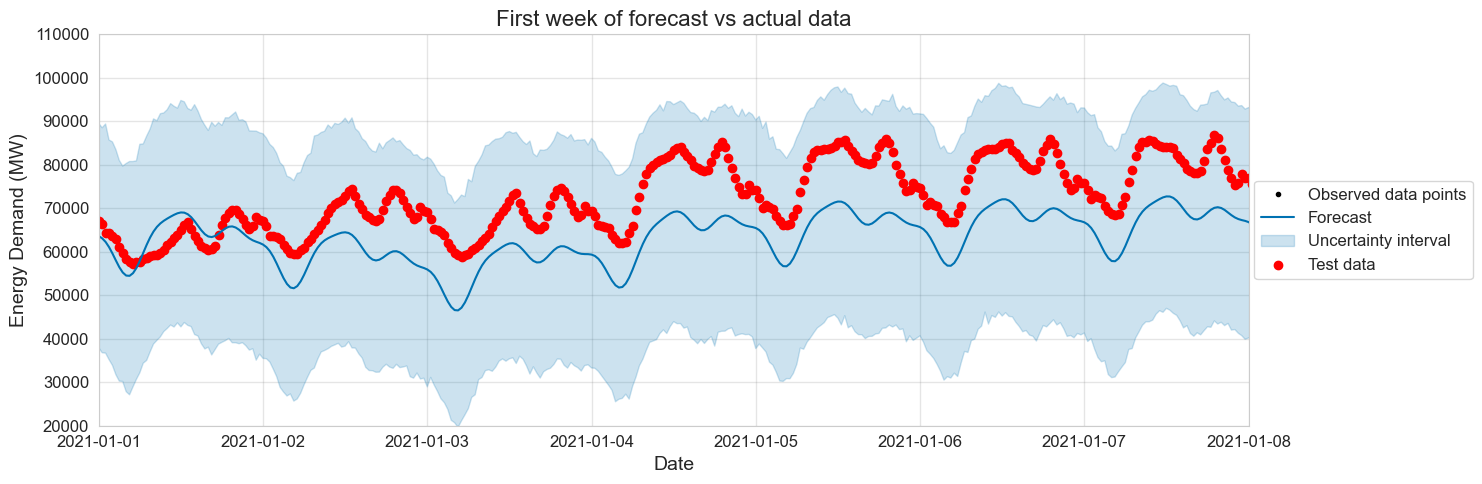

In [209]:
threshold_date = "2021-01-01"
# borne inférieure : début du test
lower = pd.to_datetime(threshold_date)

# borne supérieure : une semaine après
upper = lower + pd.Timedelta(days=7)

fig, ax = plt.subplots(figsize=(15,5))
prophet_model.plot(prophet_predict_df, ax=ax, include_legend=True)

# nettoyage au cas où
x_idx = pd.to_datetime(y_test.index, errors="coerce")
y_test_clean = y_test.loc[x_idx.notna()].copy()
y_test_clean.index = x_idx[x_idx.notna()]

ax.scatter(y_test_clean.index, y_test_clean.to_numpy(), color='r', label="Test data")

# borne X = une semaine
ax.set_xlim(lower, upper)
ax.set_ylim(20000, 110000)
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1)
ax.set_title("First week of forecast vs actual data")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date")
plt.tight_layout()


Prophet with holidays


In [202]:
holiday_df = (
    pd.DataFrame(list(metropole.items()), columns=["ds", "holiday"])
    .sort_values("ds")  # trie les dates dans l'ordre chronologique
    .reset_index(drop=True)
)

# convertir les dates en datetime (format compatible Prophet)
holiday_df["ds"] = pd.to_datetime(holiday_df["ds"])

holiday_df.head(5)

,ds,holiday
0,2012-01-01,Jour de l'an
1,2012-04-09,Lundi de Pâques
2,2012-05-01,Fête du Travail
3,2012-05-08,Fête de la Victoire
4,2012-05-17,Ascension


14:10:11 - cmdstanpy - INFO - Chain [1] start processing
14:12:48 - cmdstanpy - INFO - Chain [1] done processing


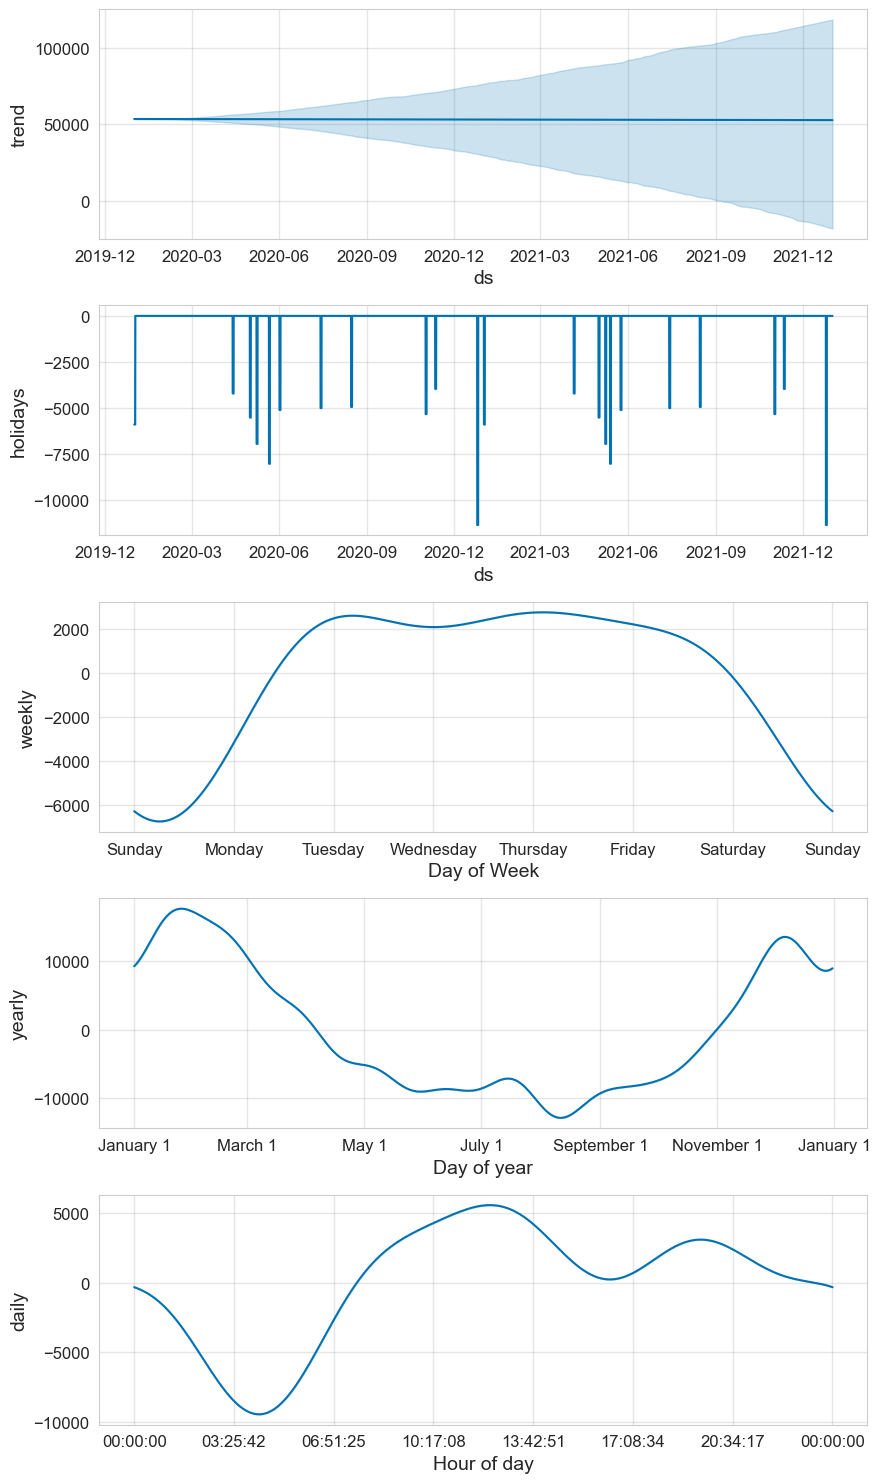

In [203]:
prophet_hol_model = Prophet(holidays=holiday_df)
prophet_hol_model.fit(train_data_prophet)

np.random.seed(43)
prophet_hol_predict_df = prophet_hol_model.predict(test_data_prophet)
prophet_hol_model.plot_components(prophet_hol_predict_df);

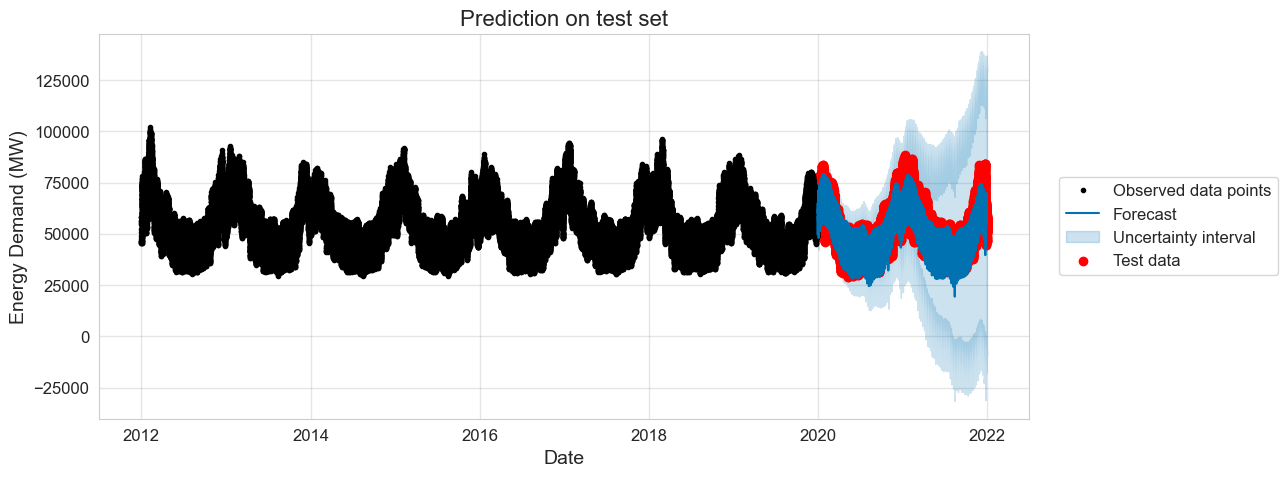

In [204]:
fig, ax = plt.subplots(figsize=(12, 5))

prophet_hol_model.plot(prophet_hol_predict_df, ax=ax, include_legend=True)
ax.scatter(y_test.to_frame().index, y_test.to_frame()["consommation"], color='r', label="Test data")
ax.legend(bbox_to_anchor=(1.15, 0.5), loc="center", ncol=1)

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

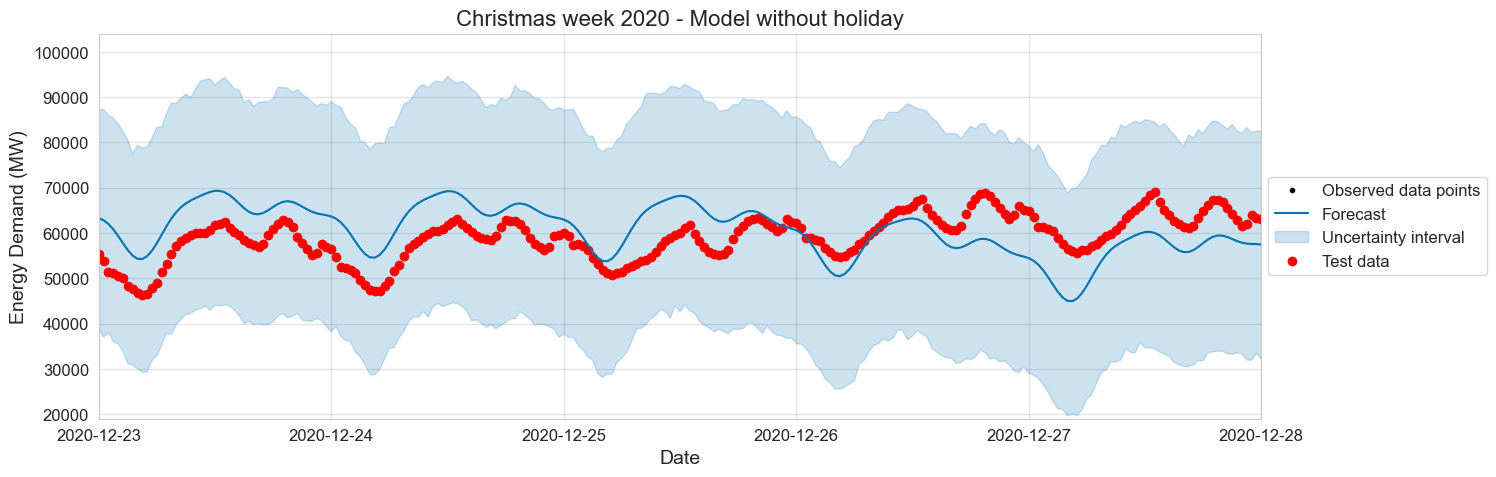

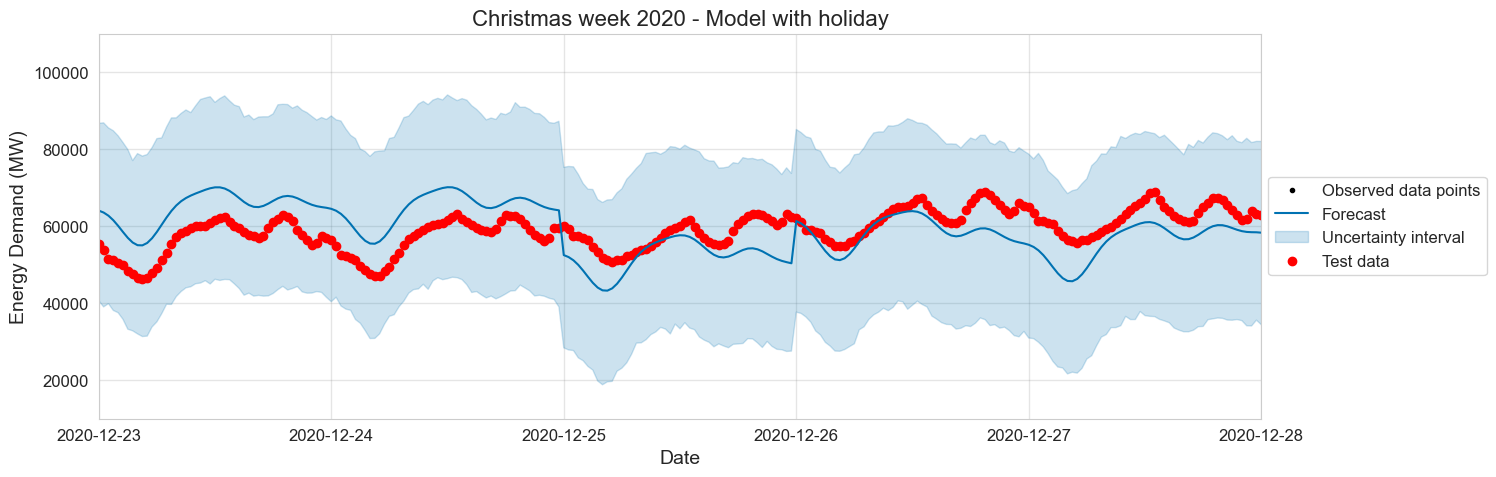

In [210]:
threshold_date_christmas_start = "2020-12-23"
threshold_date_christmas_end = "2020-12-28"
lower = pd.to_datetime(threshold_date_christmas_start)
upper = pd.to_datetime(threshold_date_christmas_end)

fig, ax = plt.subplots(figsize=(15,5))
prophet_model.plot(prophet_predict_df, ax=ax, include_legend=True)

ax.scatter(y_test.to_frame().index, y_test.to_frame()["consommation"], color='r', label="Test data")
ax.set_xlim(lower, upper)
ax.set_ylim(bottom=19000, top=104000)
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1);
ax.set_title("Christmas week 2020 - Model without holiday")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");


fig, ax = plt.subplots(figsize=(15,5))

prophet_model.plot(prophet_hol_predict_df, ax=ax, include_legend=True)
ax.scatter(y_test.to_frame().index, y_test.to_frame()["consommation"], color='r', label="Test data")
ax.set_xlim(lower, upper)
ax.set_ylim(bottom=10000, top=110000)
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1);
ax.set_title("Christmas week 2020 - Model with holiday")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

The prediction is way more accurate for the second model, proving that this functionality works, especially when many holidays are fed to the model and it can learn the pattern on those days.

It's interesting that right before and right after the holiday there's a steep change (either upwards or downwards) in the value to adjust the value to "non-holiday". The model could be improved if it picked up the trend more slowly.

In [206]:
mape_prophet_holiday = mean_absolute_percentage_error(
    y_test, prophet_hol_predict_df["yhat"]
)
rmse_prophet_holiday = np.sqrt(mean_squared_error(y_test, prophet_hol_predict_df["yhat"]))
print(
    "Mean Absolute Percentage Error of the holiday Prophet model is: %.2f"
    % mape_prophet_holiday
)
print(
    "Root Mean Squared Error of the Prophet (with holiday) model is: %.2f MW" % rmse_prophet_holiday
)

Mean Absolute Percentage Error of the holiday Prophet model is: 7.43
Root Mean Squared Error of the Prophet (with holiday) model is: 5067.81 MW


Prophet with cross-validation and grid search

Similarly to implementing cross-validation and grid search with XGBoost, I want to use these techniques together with Prophet to generate better predictions. Prophet's API includes a section that covers this. Unfortunately, I didn't manage to use the cross validation class because it took too long to run. In case you're interested in that class, the API's example is as follows:

from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')

It's worth noting that the model needs to be fitted first and the cross_validation object can be used to compute the metrics from each fold.

Also, since each model takes long to be fitted (up to 2 miniutes), I chose only 2 splits, which isn't a recommended practice, especially given that this is a large dataset,

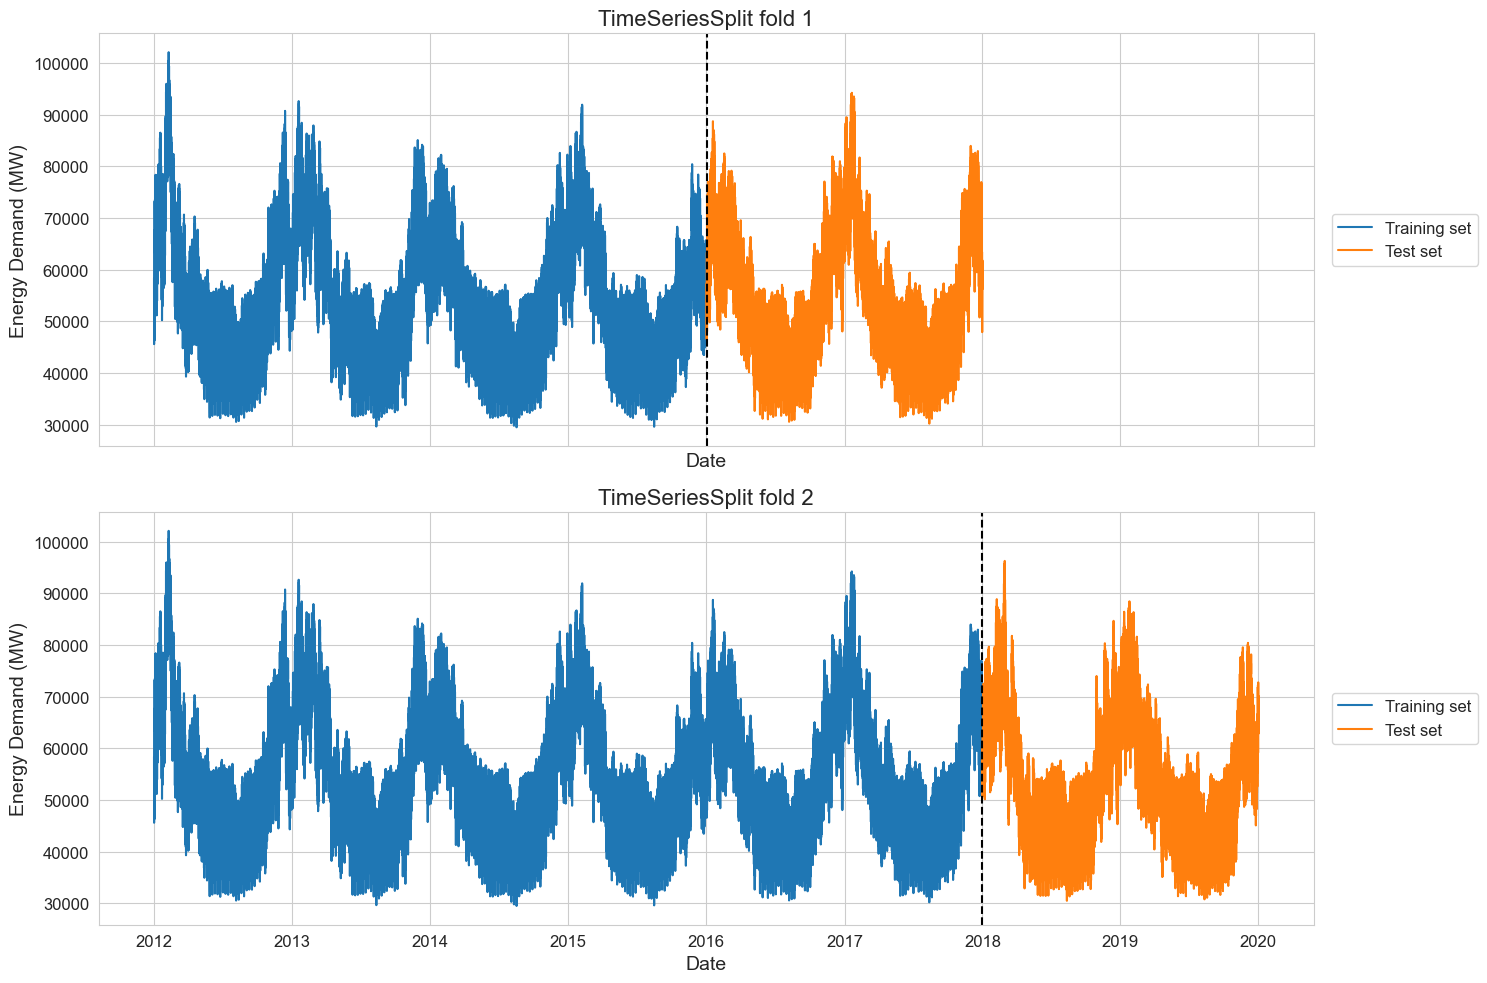

In [222]:
n_years_test = 2
tss_prophet = TimeSeriesSplit(n_splits=2, test_size=48 * 365 * n_years_test, gap=48)

# 1) On aligne la source de split et ce qu'on va tracer
base = (
    y_train.loc[y_train.index < threshold_date_1]   # même filtre que dans le split
          .to_frame()                               # -> DataFrame
          .reset_index()                            # la 1ère col = timestamps (souvent 'datetime' ou 'index')
)

time_col = base.columns[0]   # nom de la colonne temps après reset_index (ex: 'datetime' ou 'index')
val_col  = base.columns[1]   # nom de la colonne valeur (ex: 'consommation')

# sécurité : forcer en datetime
base[time_col] = pd.to_datetime(base[time_col], errors="coerce")
base = base.dropna(subset=[time_col])

fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
fold = 0

# 2) On split sur la même base
for train_index, test_index in tss_prophet.split(base):
    train_data = (base.iloc[train_index]
                      .rename(columns={time_col: "ds", val_col: "y"}))
    test_data  = (base.iloc[test_index]
                      .rename(columns={time_col: "ds", val_col: "y"}))

    # 3) Traces
    axes[fold].plot(train_data["ds"], train_data["y"], label="Training set")
    axes[fold].plot(test_data["ds"], test_data["y"], label="Test set")
    axes[fold].axvline(test_data["ds"].min(), color="k", ls="--")

    axes[fold].legend(loc="center", bbox_to_anchor=(1.075, 0.5))
    axes[fold].set_title(f"TimeSeriesSplit fold {fold+1}")
    axes[fold].set_ylabel("Energy Demand (MW)")
    axes[fold].set_xlabel("Date")
    fold += 1
plt.tight_layout()


In [224]:
# Define the parameter grid for the Prophet model
param_grid = {"changepoint_prior_scale": [0.05], "seasonality_prior_scale": [2.5, 10]}

# Create all possible combinations of the parameter grid
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

rmse_cv_gs = []

for params in all_params:
    rmse_cv = []
    
    for train_index, test_index in tss_prophet.split(df[df.index<threshold_date_1]):
        train_data = (base.iloc[train_index]
                      .rename(columns={time_col: "ds", val_col: "y"}))
        test_data  = (base.iloc[test_index]
                      .rename(columns={time_col: "ds", val_col: "y"}))

        model = Prophet(**params, holidays=holiday_df)
        model.fit(train_data)

        prediction = model.predict(test_data)
        mse_val = mean_squared_error(test_data["y"], prediction["yhat"])
        rmse_cv.append(np.sqrt(mse_val))
    
    rmse_cv_gs.append(np.mean(rmse_cv))
    
grid_search_results = pd.DataFrame(all_params)
grid_search_results['rmse'] = rmse_cv_gs

grid_search_results

14:26:41 - cmdstanpy - INFO - Chain [1] start processing
14:28:17 - cmdstanpy - INFO - Chain [1] done processing
14:28:33 - cmdstanpy - INFO - Chain [1] start processing
14:30:50 - cmdstanpy - INFO - Chain [1] done processing
14:31:03 - cmdstanpy - INFO - Chain [1] start processing
14:32:41 - cmdstanpy - INFO - Chain [1] done processing
14:32:56 - cmdstanpy - INFO - Chain [1] start processing
14:34:52 - cmdstanpy - INFO - Chain [1] done processing


,changepoint_prior_scale,seasonality_prior_scale,rmse
0,0.05,2.5,14185.706379
1,0.05,10.0,14142.896015


In [225]:
best_params = all_params[np.argmin(rmse_cv_gs)]
print(best_params)

{'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10}


In [226]:
# Create Prophet using the best parameters from the grid search
prophet_best = Prophet(**best_params, holidays=holiday_df)
prophet_best.fit(train_data_prophet)

prophet_best_predict_df = prophet_best.predict(test_data_prophet)

# Compute MAPE value
mape_prophet_cv_gs = mean_absolute_percentage_error(
    y_test, prophet_best_predict_df["yhat"]
)
rmse_prophet_cv_gs = np.sqrt(
    mean_squared_error(y_test, prophet_best_predict_df["yhat"])
)
print(
    "Mean Absolute Percentage Error of the best-parameters Prophet model is: %.2f"
    % mape_prophet_cv_gs
)
print(
    "Root Mean Squared Error of the Prophet (with cross-validation) model is: %.2f MW" % rmse_prophet_cv_gs
)

14:35:39 - cmdstanpy - INFO - Chain [1] start processing
14:38:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error of the best-parameters Prophet model is: 7.43
Root Mean Squared Error of the Prophet (with cross-validation) model is: 5067.81 MW


### Prediction to the future

In [ ]:
# Fit a new model using all the data as training data
prophet_future_model = Prophet(**best_params, holidays=holiday_df)
prophet_future_model.fit(all_data_prophet)

# Make predictions on future dataframe
prophet_future = prophet_future_model.make_future_dataframe(periods=210*24, freq="H", include_history=False)
prophet_fut_forecast = prophet_future_model.predict(prophet_future)

14:38:43 - cmdstanpy - INFO - Chain [1] start processing


In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(prophet_fut_forecast["ds"], prophet_fut_forecast["yhat"])

ax.set_xlabel("Date")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Future demand prediction");

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(
        df_and_future_wprediction.index, 
        df_and_future_wprediction["pred_xgboost"], 
        label = "XGBoost prediction"
        )
ax.plot(
        prophet_fut_forecast["ds"], 
        prophet_fut_forecast["yhat"], 
        label = "Prophet prediction", 
        alpha = 0.75
        )

ax.set_xlabel("Date")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Prediction comparison")

ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1);